In [1]:
from pyspark.sql import SQLContext, Row, DataFrame, HiveContext, SparkSession
from pyspark.sql.functions import udf, col, lit, when, min as sql_min
from pyspark.sql.types import *

sqlContext = SQLContext(sc)
sqlContext_H = HiveContext(sc)

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from datetime import datetime, date
import dateutil
import pandas as pd
import numpy as np
from collections import OrderedDict
from random import randint
from pyspark.sql.window import Window
import pyspark.sql.functions as func
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#HOST = ''
HOST = 'hdfs://ip-10-0-0-159.ec2.internal:8020'

In [4]:
%%time

data = sqlContext_H.read.parquet(
    #HOST + "../../hdfs/Epic_Access_Log_20160410.parquet",
    #HOST + "../../hdfs/Epic_Access_Log_20160411.parquet",
    #HOST + "../../hdfs/Epic_Access_Log_20160412.parquet"
    HOST + "/parquet/07/*",
    HOST + "/parquet/08/*",
    HOST + "/parquet/09/*"
)

def convert_dttm(x):
    try:
        return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    except:
        return None
convert_dttm_udf =  udf(convert_dttm, TimestampType())

data = data.withColumn(
        "ACCESS_DTTM", convert_dttm_udf(col("ACCESS_DTTM"))
    ).withColumn(
        "ADMISSION_DTTM", convert_dttm_udf(col("ADMISSION_DTTM"))
    ).withColumn(
        "DISCHARGE_DTTM", convert_dttm_udf(col("DISCHARGE_DTTM"))
    )

CPU times: user 7.33 ms, sys: 344 µs, total: 7.67 ms
Wall time: 3.24 s


In [5]:
data.limit(10).toPandas()

,ACCESS_DTTM,ACCESS_LOG_TYPE,ADMISSION_DTTM,BTG_ACTION,BTG_EXPLANATION,BTG_REASON,DISCHARGE_DTTM,ENCOUNTER_CSN,ENCOUNTER_DEPARTMENT,ENCOUNTER_PROVIDER_ID,ENCOUNTER_PROVIDER_NAME,ENCOUNTER_PROVIDER_NPI,ENCOUNTER_SERVICE_AREA,ENCOUNTER_TYPE,ENVIRONMENT,EPIC_ENTERPRISE_MRN_ID,EPIC_PATIENT_ID,HOSPITAL_ACCOUNT_RECORD_ID,INDEX_LOGGED_UTC_CHRON_INST,METRIC_DESCRIPTION,METRIC_ID,METRIC_NAME,MNEMONIC_ID,MNEMONIC_VALUE,MODULE,MRN_TYPE_2_ID,PATIENT_ADDRESS_LINE_1,PATIENT_ADDRESS_LINE_2,PATIENT_BIRTH_DATE,PATIENT_CITY,PATIENT_DEATH_DATE,PATIENT_EMPLOYER,PATIENT_ETHNICITY,PATIENT_FIRST_NAME,PATIENT_GENDER,PATIENT_HOME_PHONE,PATIENT_LAST_NAME,PATIENT_MARITAL_STATUS,PATIENT_MIDDLE_NAME,PATIENT_STATE,PATIENT_STATUS,PATIENT_ZIP,PCP_PROVIDER_ID,PCP_PROVIDER_NAME,PCP_PROVIDER_NPI,PROCESS_ID,REPORT_NAME,USER_ID,USER_NAME,USER_PROVIDER_ID,USER_PROVIDER_NAME,USER_PROVIDER_NPI,USER_STATUS,USER_SYSTEM_LOGIN,VISIT_DATE,WORKSTATION
0,2016-08-05 11:47:47,Type 3 Access Event,None,,,,None,88749443,CLAY ANTICOAG CLINIC,5121,HIN ANTICOAG CLINIC,,"DMG-GLEN ELLYN CLINIC, S.C.",Anti-coag visit,prd,GE11132675,4250968,,5541324467.976515,Patient Address subcomponent accessed on Patie...,15047,REG_EPTADDRESS,,,PATIENT DEMOGRAPHICS,1794333,6862 FIELDSTONE DR,,1970-09-26 00:00:00,BURR RIDGE,,OTHER,NON HISPANIC OR LATINO OR LATINO ETHNICITY,Caroline,Female,630-738-1888,Potter,Married,,Illinois,Alive,60527,3080,"KOLIOPOULOS, ELIAS J",1003074519,prd-34538158,,17404,"JONAS, HELEN I",,,,ACTIVE,HIJONAS,2016-08-05 00:00:00,HY6100
1,2016-08-05 14:41:00,Type 5 Access Event,None,,,,None,,,,,,,,prd,GE11630631,5418523,,5541334860.258170,Results are displayed,51001,LAB_RESULT_DISPLAYED,,,DEMOGRAPHIC,2961794,1421 FOREST RD,,1944-01-05 00:00:00,LA GRANGE PARK,,OTHER,NON HISPANIC OR LATINO OR LATINO ETHNICITY,James,Male,708-606-8902,Hurley,Widowed,D,Illinois,Alive,60526,112184,"HARAZIN, JAMES",1255410072,prd-54133248,,14456,"SHEHU, JETMIR",,,,ACTIVE,JSHEHU,,HY6227
2,2016-08-05 14:41:00,Type 3 Access Event,None,,,,None,,,,,,,,prd,1880917,4337661,,5541334860.407202,Care Everywhere Documents activity accessed.,72000,CE_DOCUMENTS,,,PATIENT CLINICAL INFO,1880917,21W700 GLEN VALLEY DR,,1965-12-17 00:00:00,GLEN ELLYN,,OTHER,NON HISPANIC OR LATINO OR LATINO ETHNICITY,Karen,Female,630-790-1118,Moutvic,Married,,Illinois,Alive,60137,9999998,"PCP, NONE",,prd-52756522,Exit,1459,"SIVER, DIANE",4997,"SIVER, DIANE",,ACTIVE,DSIVER,,HY5143
3,2016-08-05 14:41:00,Type 5 Access Event,None,,,,None,,,,,,,,prd,GE37810025,Z3241635,,5541334860.753678,A report with patient data accessed.,17008,MR_REPORTS,,AMB HOME MEDS (NAVIGATOR) - NO ACTIVE,PATIENT CLINICAL INFO,638457,125 HARDING DR,,1979-02-21 00:00:00,GLENDALE HEIGHTS,,OTHER,NON HISPANIC OR LATINO OR LATINO ETHNICITY,Robert,Male,630-479-4789,Quigley,Married,J,Illinois,Alive,60139,3960,"RAIKAR, LEENA",1114242302,prd-17499692,View,12039,"RAIKAR, LEENA",3960,"RAIKAR, LEENA",1114242302,ACTIVE,RAIKAL3,,WS1998
4,2016-08-05 14:41:00,Type 3 Access Event,None,,,,None,,,,,,,,prd,GE37810025,Z3241635,,5541334860.850432,Event for order transmittal action,17162,MR_ORDER_TRANSMITTAL,,,PATIENT ORDERS,638457,125 HARDING DR,,1979-02-21 00:00:00,GLENDALE HEIGHTS,,OTHER,NON HISPANIC OR LATINO OR LATINO ETHNICITY,Robert,Male,630-479-4789,Quigley,Married,J,Illinois,Alive,60139,3960,"RAIKAR, LEENA",1114242302,prd-1115886,Printed/Sent by Order Transmittal,12039,"RAIKAR, LEENA",3960,"RAIKAR, LEENA",1114242302,ACTIVE,RAIKAL3,,
5,2016-08-05 14:41:00,Type 3 Access Event,None,,,,None,,,,,,,,prd,GE37810025,Z3241635,,5541334860.855903,Event for order transmittal action,17162,MR_ORDER_TRANSMITTAL,,,PATIENT ORDERS,638457,125 HARDING DR,,1979-02-21 00:00:00,GLENDALE HEIGHTS,,OTHER,NON HISPANIC OR LATINO OR LATINO ETHNICITY,Robert,Male,630-479-4789,Quigley,Married,J,Illinois,Alive,60139,3960,"RAIKAR, LEENA",1114242302,prd-1115886,Printed/Sent by Order Transmittal,12039,"RAIKAR, LEENA",3960,"RAIKAR, LEENA",1114242302,ACTIVE,RAIKAL3,,
6,2016-08-05 11:47:47,Type 1 Access Event,None,,,,None,

---
### 1. Select fields

In [6]:
#data_analysis.unpersist()
columns = ["ACCESS_DTTM", "USER_ID", "METRIC_NAME", "MODULE", "EPIC_PATIENT_ID", "REPORT_NAME", "METRIC_DESCRIPTION"]
data_analysis = data.select(columns).persist()
data_analysis.limit(3).toPandas()

,ACCESS_DTTM,USER_ID,METRIC_NAME,MODULE,EPIC_PATIENT_ID,REPORT_NAME,METRIC_DESCRIPTION
0,2016-08-05 11:47:47,17404,REG_EPTADDRESS,PATIENT DEMOGRAPHICS,4250968,,Patient Address subcomponent accessed on Patie...
1,2016-08-05 14:41:00,14456,LAB_RESULT_DISPLAYED,DEMOGRAPHIC,5418523,,Results are displayed
2,2016-08-05 14:41:00,1459,CE_DOCUMENTS,PATIENT CLINICAL INFO,4337661,Exit,Care Everywhere Documents activity accessed.


In [7]:
sqlContext_H.registerDataFrameAsTable(data_analysis, "data_analysis")

In [8]:
def draw_plot(rdd, x, y, n, title=''):
    X = rdd.rdd.map(lambda p: p[x]).take(n)
    Y = rdd.rdd.map(lambda p: p[y]).take(n)
    fig = plt.figure(figsize=(18,6))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    width = .35
    ind = np.arange(len(Y))
    plt.bar(ind, Y, width=width)
    plt.xticks(ind + width / 2, X)
    
    fig.autofmt_xdate()

    print('\n')

---
### 2. Amount of unique modules, unique metrics

In [9]:
%%time
query = " ".join([
        "SELECT COUNT(DISTINCT MODULE) AS DISTINCT_MODULE",
        "FROM data_analysis",
    ])
u_mo = sqlContext_H.sql(query)
u_mo.show()

+---------------+
|DISTINCT_MODULE|
+---------------+
|             39|
+---------------+

CPU times: user 232 ms, sys: 44.4 ms, total: 276 ms
Wall time: 54min 51s


In [10]:
%%time
query = " ".join([
        "SELECT COUNT(DISTINCT METRIC_NAME) AS DISTINCT_METRIC_NAME",
        "FROM data_analysis",
    ])
u_me = sqlContext_H.sql(query)
u_me.show()

+--------------------+
|DISTINCT_METRIC_NAME|
+--------------------+
|                 689|
+--------------------+

CPU times: user 16.8 ms, sys: 8.58 ms, total: 25.4 ms
Wall time: 18.1 s


---
> * Total unique MODULE amount is 39.
> * Total unique METRIC_NAME amount is 689.

---

---
### 3. Percentage of records with undefined modules and metrics

In [11]:
%%time
total_rows = data_analysis.rdd.count()
print "Total rows in datasset: {}".format(total_rows)

Total rows in datasset: 592518304


In [46]:
%%time
query = " ".join([
    "SELECT *",
    "FROM data_analysis",
    "WHERE MODULE = ''",
    "OR MODULE = 'None'",
    "OR MODULE = null"
])
u_mo = sqlContext_H.sql(query)
c_u_mo = u_mo.rdd.count()
c_u_mo

24885512

In [47]:
%%time
per_mo = (c_u_mo*100.0)/total_rows
print "Percentage of rows where MODULE is undefined: {:.2f}%".format(per_mo)

Percentage of rows where MODULE is undefined: 4.20%
CPU times: user 338 µs, sys: 0 ns, total: 338 µs
Wall time: 194 µs


In [48]:
%%time
query = " ".join([
    "SELECT *",
    "FROM data_analysis",
    "WHERE METRIC_NAME = ''",
    "OR METRIC_NAME = 'None'",
    "OR METRIC_NAME = null"
])
u_me = sqlContext_H.sql(query)
c_u_me = u_me.rdd.count()
c_u_me

0

In [49]:
%%time
per_me = (c_u_me*100.0)/total_rows
print "Percentage of rows where METRIC_NAME is undefined: {:.2f}%".format(per_me)

Percentage of rows where METRIC_NAME is undefined: 0.00%
CPU times: user 736 µs, sys: 0 ns, total: 736 µs
Wall time: 688 µs


---
> * There are about 4% records where a MODULE is undefined.
> * All records have a METRIC_NAME.

---

---
### 4. Whether some metric exists in two or more modules

In [16]:
query = " ".join([
    "SELECT MODULE, COUNT(DISTINCT METRIC_NAME) AS AMOUNT",
    "FROM data_analysis",
    "GROUP BY MODULE",
    "ORDER BY AMOUNT DESC",
])

a_mo = sqlContext_H.sql(query)
MODULEs_names = a_mo.toPandas()["MODULE"].values.tolist()
var_names = [ 'no_n' if i == '' else i.replace(' ', '_') for i in MODULEs_names]
a_mo.limit(20).toPandas()

,MODULE,AMOUNT
0,PATIENT CLINICAL INFO,187
1,PATIENT DEMOGRAPHICS,84
2,Hospital Encounter,71
3,PATIENT HOSPITAL ACCOUNT,51
4,LOG ENTRY,31
5,Patient Chart Review,29
6,PATIENT COVERAGE,27
7,AC Rep Settings,23
8,CASE ENTRY,19
9,PATIENT ACCOUNT,17


In [19]:
%%time
for index, module in enumerate(MODULEs_names):
    globals()['sql_' + var_names[index]] = sqlContext_H.sql("SELECT METRIC_NAME FROM data_analysis WHERE MODULE='{}'".format(module))
    globals()['df_' + var_names[index]] = globals()['sql_' + var_names[index]].rdd.map(lambda p: p['METRIC_NAME']).distinct().collect()

CPU times: user 1.54 s, sys: 412 ms, total: 1.95 s
Wall time: 18min 57s


In [23]:
from collections import defaultdict
metric_in = defaultdict(list)
for module in var_names:
    temp_l = var_names[:]
    temp_l.remove(module)
    one_set = set()
    #print module
    #print 'temp_l ----- ', temp_l
    for name in temp_l:
        one_set = one_set.union(set(globals()['df_' + name]))
    #print '----->>>> ', one_set, '/n'
    for METRIC_NAME in set(globals()['df_' + module]):
        #print '#######  ', METRIC_NAME
        if METRIC_NAME in one_set:
            metric_in[module].append(METRIC_NAME)
            print METRIC_NAME
if metric_in == {}:
    print "0 metric exists"
else:
    print metric_in

0 metric exists


---
> * Each module has its own metrics!

---

---
### 5. Top 25 modules by usage (records where it was selected) and by popularity among users / patients

In [ ]:
%%time
query = " ".join([
    "SELECT MODULE, COUNT(MODULE) AS AMOUNT, COUNT(DISTINCT USER_ID) AS COUNT_USERS, COUNT(DISTINCT EPIC_PATIENT_ID) AS COUNT_PATIENTS",
    "FROM data_analysis",
    "GROUP BY MODULE",
    "ORDER BY AMOUNT DESC",
])

a_mo = sqlContext_H.sql(query)
top_20_modules = a_mo.limit(20).toPandas()['MODULE'].values.tolist()

In [9]:
%%time

a_mo.limit(25).toPandas()

CPU times: user 34.8 ms, sys: 0 ns, total: 34.8 ms
Wall time: 1min 5s


,MODULE,AMOUNT,COUNT_USERS,COUNT_PATIENTS
0,PATIENT CLINICAL INFO,314047006,12270,820209
1,Patient Chart Review,54206633,10788,627292
2,PATIENT DEMOGRAPHICS,39904816,11016,653506
3,In Basket Report,29929177,5963,456388
4,,24885512,3625,333284
5,AC Rep Settings,22759963,9042,101313
6,PATIENT ORDERS,19335928,9694,471758
7,Hospital Encounter,14321785,4255,192066
8,Printing,11873849,9579,454324
9,Undefined,9626087,451,18445


---
> * Top 5 MODULEs by usages:
> > - PATIENT CLINICAL INFO
> > - Patient Chart Review
> > - PATIENT DEMOGRAPHICS
> > - In Basket Report
> > - ' ' (UNDEFINED)

---

---
### 6. Top 25 metrics by usage (records where it was selected) and by popularity among users / patients

In [26]:
query = " ".join([
    "SELECT METRIC_NAME, COUNT(METRIC_NAME) AS AMOUNT, COUNT(DISTINCT USER_ID) AS COUNT_USERS, COUNT(DISTINCT EPIC_PATIENT_ID) AS COUNT_PATIENTS",
    "FROM data_analysis",
    "GROUP BY METRIC_NAME",
    "ORDER BY AMOUNT DESC",
])

a_me = sqlContext_H.sql(query)

In [27]:
%%time
a_me.limit(25).toPandas()

CPU times: user 30.6 ms, sys: 9.43 ms, total: 40.1 ms
Wall time: 1min 42s


,METRIC_NAME,AMOUNT,COUNT_USERS,COUNT_PATIENTS
0,MR_REPORTS,127893611,11769,670623
1,IB_VIEWEDMESSAGE,29922128,5809,456388
2,AC_DOCUMENTLIST_SUBC,24826346,3490,333284
3,AS_DEPT_APPT_REPORT,16723428,2376,1
4,MR_ENC_ENCOUNTER,16566773,8279,502497
5,IP_NOTES,14690707,7183,418714
6,ADT_PATIENT_STATION,12088929,2537,64187
7,MR_CHART_REVIEW_ORDER_VIEWED,12024249,9027,325467
8,UCW_RELATED_ENCOUNTERS,11616342,8521,427125
9,E_PRINT,11452739,9553,454317


---
> * Top 5 METRIC_NAMEs by usages:
> > - MR_REPORTS
> > - IB_VIEWEDMESSAGE
> > - AC_DOCUMENTLIST_SUBC
> > - AS_DEPT_APPT_REPORT
> > - MR_ENC_ENCOUNTER

---

---
### 7. Find for each top 10-20 modules which top 5-10 metrics users use when looking profiles of patients

In [28]:
#top_20_modules = [u'PATIENT CLINICAL INFO', u'Patient Chart Review', u'PATIENT DEMOGRAPHICS', u'In Basket Report', u'', u'AC Rep Settings', u'PATIENT ORDERS', u'Hospital Encounter', u'Printing', u'Undefined', u'PATIENT COVERAGE', u'PATIENT ACCOUNT', u'MASTER FILE/ADMIN', u'PATIENT HOSPITAL ACCOUNT', u'DEMOGRAPHIC', u'PATIENT CHART', u'Eligibility EDI', u'PCP History', u'Account Inquiry', u'LOG ENTRY']
print top_20_modules
l = ["MODULE = '{}'".format(i) for i in top_20_modules]
insert_modules = ' OR '.join(l)
insert_modules

[u'PATIENT CLINICAL INFO', u'Patient Chart Review', u'PATIENT DEMOGRAPHICS', u'In Basket Report', u'', u'AC Rep Settings', u'PATIENT ORDERS', u'Hospital Encounter', u'Printing', u'Undefined', u'PATIENT COVERAGE', u'PATIENT ACCOUNT', u'MASTER FILE/ADMIN', u'PATIENT HOSPITAL ACCOUNT', u'DEMOGRAPHIC', u'PATIENT CHART', u'Eligibility EDI', u'PCP History', u'Account Inquiry', u'LOG ENTRY']


"MODULE = 'PATIENT CLINICAL INFO' OR MODULE = 'Patient Chart Review' OR MODULE = 'PATIENT DEMOGRAPHICS' OR MODULE = 'In Basket Report' OR MODULE = '' OR MODULE = 'AC Rep Settings' OR MODULE = 'PATIENT ORDERS' OR MODULE = 'Hospital Encounter' OR MODULE = 'Printing' OR MODULE = 'Undefined' OR MODULE = 'PATIENT COVERAGE' OR MODULE = 'PATIENT ACCOUNT' OR MODULE = 'MASTER FILE/ADMIN' OR MODULE = 'PATIENT HOSPITAL ACCOUNT' OR MODULE = 'DEMOGRAPHIC' OR MODULE = 'PATIENT CHART' OR MODULE = 'Eligibility EDI' OR MODULE = 'PCP History' OR MODULE = 'Account Inquiry' OR MODULE = 'LOG ENTRY' OR "

In [ ]:
query = " ".join([
        "select MODULE, METRIC_NAME, AMOUNT",
        "FROM ("
        "select MODULE, METRIC_NAME, AMOUNT,",
        "row_number() over(partition by MODULE order by AMOUNT desc) as rn",
        "from (SELECT MODULE, METRIC_NAME, COUNT(METRIC_NAME) AS AMOUNT FROM data_analysis GROUP BY MODULE, METRIC_NAME) AS T"
        ") AS T",
        "where rn <= 10",
        "ORDER BY MODULE DESC, AMOUNT DESC"
    ])
group_t = sqlContext_H.sql(query).filter(insert_modules).persist()

In [29]:
group_t.limit(50).toPandas()

,MODULE,METRIC_NAME,AMOUNT
0,Undefined,IC_SERVICE_AUDIT,9601221
1,Undefined,AC_SMARTPHRASE_ACCESS,14033
2,Undefined,AC_SMARTLIST_ACCESS,10833
3,Printing,E_PRINT,11452739
4,Printing,AS_VISIT_LABEL_PRINT,409219
5,Printing,AC_WORKBENCH_PRINT,8189
6,Printing,AS_ENC_FORM_PRINT,3702
7,Patient Chart Review,MR_CHART_REVIEW_ORDER_VIEWED,12024249
8,Patient Chart Review,MR_CHART_REVIEW_ENCOUNTER_VIEWED,8995441
9,Patient Chart Review,MR_REVIEW_LETTERS,8591752


In [ ]:
%%time
group_t.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_7_MODULE_METRIC_NAME.csv")

---
> * We find top mitrics for each module. In the future we compare the importance of each metrics by using ACCESS_LOG_TYPE


---

---
### 8. Find all records related with record printing (this info may also be in METRIC_DESCRIPTION field) and investigate its dynamics

In [9]:
%%time
def f1(x):
    return str(x.date())

def f2(x):
    return x.hour

def f3(c1, c2, c3):
    if 'print' in (c1 + ' ' + c2 + ' ' + c3).lower():
        return 1
    else:
        return 0

#dow_udf = udf(f1, IntegerType())
dow_udf = udf(f1, StringType())
time_udf = udf(f2, IntegerType())
f_udf = udf(f3, IntegerType())

check_df = data_analysis.withColumn("CKECK", f_udf(col("METRIC_DESCRIPTION"), col("MODULE"), col("METRIC_NAME")))\
                        .withColumn("DAY", dow_udf(col("ACCESS_DTTM")))\
                        .withColumn("TIME_OF_DAY", time_udf(col("ACCESS_DTTM")))
                       #.withColumn("DAY_OF_WEEK", dow_udf(col("ACCESS_DTTM")))\
sqlContext_H.registerDataFrameAsTable(check_df, 'check_df')

CPU times: user 12.1 ms, sys: 497 µs, total: 12.6 ms
Wall time: 79.7 ms


In [10]:
%%time
query = " ".join([
        "SELECT *",
        "FROM check_df",
        "WHERE CKECK = 1 OR REPORT_NAME = 'Print' OR REPORT_NAME = 'Printed/Sent by Order Transmittal'"
    ])
with_print = sqlContext_H.sql(query)
sqlContext_H.registerDataFrameAsTable(with_print, 'with_print')

CPU times: user 869 µs, sys: 137 µs, total: 1.01 ms
Wall time: 93.2 ms


In [11]:
%%time
with_print.limit(5).toPandas()

CPU times: user 2.03 ms, sys: 4.08 ms, total: 6.11 ms
Wall time: 7.52 s


,ACCESS_DTTM,USER_ID,METRIC_NAME,MODULE,EPIC_PATIENT_ID,REPORT_NAME,METRIC_DESCRIPTION,CKECK,DAY,TIME_OF_DAY
0,2016-08-05 14:41:00,12039,MR_ORDER_TRANSMITTAL,PATIENT ORDERS,Z3241635,Printed/Sent by Order Transmittal,Event for order transmittal action,0,2016-08-05,14
1,2016-08-05 14:41:00,12039,MR_ORDER_TRANSMITTAL,PATIENT ORDERS,Z3241635,Printed/Sent by Order Transmittal,Event for order transmittal action,0,2016-08-05,14
2,2016-08-05 14:40:59,205459,MR_REPORTS,PATIENT CLINICAL INFO,4167429,Print,A report with patient data accessed.,0,2016-08-05,14
3,2016-08-05 14:40:59,206950,MR_FLOWSHEET,PATIENT CLINICAL INFO,Z3738487,Print,Flowsheets activity selected.,0,2016-08-05,14
4,2016-08-05 11:47:46,13968,E_PRINT,Printing,4378112,,Specifies a printout or part of a printout. Us...,1,2016-08-05,11


In [12]:
%%time
query = " ".join([
        "SELECT concat_ws(';', collect_set(METRIC_NAME)) AS METRIC_NAME,",
        "concat_ws(';', collect_set(MODULE)) AS MODULE,",
        "concat_ws(';', collect_set(METRIC_DESCRIPTION)) AS METRIC_DESCRIPTION",
        "FROM with_print",
        #"GROUP BY METRIC_NAME, MODULE, METRIC_DESCRIPTION"
    ])
collect_df = sqlContext_H.sql(query)

CPU times: user 1.24 ms, sys: 192 µs, total: 1.43 ms
Wall time: 58 ms


In [13]:
%%time
collect_df.limit(10).toPandas()

CPU times: user 165 ms, sys: 36.2 ms, total: 202 ms
Wall time: 31min 28s


,METRIC_NAME,MODULE,METRIC_DESCRIPTION
0,MR_EDUCATIONAL_IMAGES;MC_MEMNOTEPRINT;MR_GROWT...,Patient Chart Review;Hospital Encounter;Notes;...,This event is logged when the user prints clin...


In [14]:
collect_df_pd = collect_df.toPandas()

In [20]:
m_n_l = [i for i in collect_df_pd['METRIC_NAME'].values.tolist()[0].split(';') if 'print' in i.lower()]
filter_metric = "WHERE " + ' OR '.join(["METRIC_NAME = '{0}'".format(i) for i in m_n_l])

In [21]:
filter_metric

"WHERE METRIC_NAME = 'MC_MEMNOTEPRINT' OR METRIC_NAME = 'MR_CHART_REVIEW_NOTE_PRINTED' OR METRIC_NAME = 'AC_WORKBENCH_PRINT' OR METRIC_NAME = 'IP_PATLIST_CLIENT_PRINT' OR METRIC_NAME = 'MC_CLMNOTEPRINT' OR METRIC_NAME = 'MR_CHART_REVIEW_REFERRAL_PRINTED' OR METRIC_NAME = 'MC_RFLNOTEPRINT' OR METRIC_NAME = 'AS_VISIT_LABEL_PRINT' OR METRIC_NAME = 'MC_CRMNOTEPRINTHS' OR METRIC_NAME = 'MR_CHART_REVIEW_MISC_PRINTED' OR METRIC_NAME = 'PRINT NOTES FROM INPATIENT NOTES ACTIVITY' OR METRIC_NAME = 'AS_ENC_FORM_PRINT' OR METRIC_NAME = 'E_PRINT' OR METRIC_NAME = 'PRINT PREVIEW CLICKED FROM INPATIENT NOTES ACTIVITY' OR METRIC_NAME = 'MR_CHART_REVIEW_ENCOUNTER_PRINTED' OR METRIC_NAME = 'MR_CHART_REVIEW_MEDIA_PRINTED' OR METRIC_NAME = 'MR_ENC_LETTERS_PRINT' OR METRIC_NAME = 'ADT_FORM_REPRINTS' OR METRIC_NAME = 'MR_CHART_REVIEW_ORDER_PRINTED' OR METRIC_NAME = 'ADT_FRM_REPRINT_SHOW_REPORT' OR METRIC_NAME = 'MR_CHART_REVIEW_EPISODE_PRINTED'"

In [22]:
print "Distinct values of METRIC_NAME: {}".format(len(m_n_l))

Distinct values of METRIC_NAME: 21


In [23]:
print m_n_l

[u'MC_MEMNOTEPRINT', u'MR_CHART_REVIEW_NOTE_PRINTED', u'AC_WORKBENCH_PRINT', u'IP_PATLIST_CLIENT_PRINT', u'MC_CLMNOTEPRINT', u'MR_CHART_REVIEW_REFERRAL_PRINTED', u'MC_RFLNOTEPRINT', u'AS_VISIT_LABEL_PRINT', u'MC_CRMNOTEPRINTHS', u'MR_CHART_REVIEW_MISC_PRINTED', u'PRINT NOTES FROM INPATIENT NOTES ACTIVITY', u'AS_ENC_FORM_PRINT', u'E_PRINT', u'PRINT PREVIEW CLICKED FROM INPATIENT NOTES ACTIVITY', u'MR_CHART_REVIEW_ENCOUNTER_PRINTED', u'MR_CHART_REVIEW_MEDIA_PRINTED', u'MR_ENC_LETTERS_PRINT', u'ADT_FORM_REPRINTS', u'MR_CHART_REVIEW_ORDER_PRINTED', u'ADT_FRM_REPRINT_SHOW_REPORT', u'MR_CHART_REVIEW_EPISODE_PRINTED']


In [24]:
mo_l = [i for i in collect_df_pd['MODULE'].values.tolist()[0].split(';') if 'print' in i.lower()]
filter_module = "WHERE " + ' OR '.join(["MODULE = '{0}'".format(i) for i in mo_l])

In [25]:
print "Distinct values of MODULE: {}".format(len(mo_l))

Distinct values of MODULE: 1


In [26]:
print mo_l

[u'Printing']


In [27]:
me_d = [i for i in collect_df_pd['METRIC_DESCRIPTION'].values.tolist()[0].split(';') if 'print' in i.lower()]
filter_metric_des = "WHERE " + ' OR '.join(["METRIC_DESCRIPTION = '{0}'".format(i) for i in me_d])

In [28]:
print "Distinct values of METRIC_DESCRIPTION: {}".format(len(me_d))

Distinct values of METRIC_DESCRIPTION: 24


In [29]:
print me_d

[u'This event is logged when the user prints clinical notes from the Notes activity.', u'This event indicates that a report for a single encounter in a Chart Review Encounters tab was printed.', u'IP note activity print preview opened. The user may or may not continue printing the notes.', u'Form Reprints activity accessed for patient.', u'A Letter is printed for the Letters activity.', u'This event indicates that a report for a single report in the Chart Review Misc Reports tab was printed.', u'Logs client printing from Comm Mgt section.', u'This event indicates that a report for a single referral in the Chart Review Referrals tab was printed.', u'Images launched in a PACS, either through print groups 53075 or 53076 or via PACS buttons or auto- query settings in imaging applications.', u'This event indicates that a report for a single note in the Chart Review Notes tab was printed.', u'Encounter Form printed from Cadence.', u'Note attached to a CRM with a patient as the source or subj

#### 8.1 How many users have these metrics / modules / metric descriptions

In [30]:
%%time
u_users_c = with_print.select("USER_ID").distinct().rdd.count()
print "Users has these metrics/modules/metric_descriptions: {}".format(u_users_c)

Users has these metrics/modules/metric_descriptions: 10728
CPU times: user 44.6 ms, sys: 22.3 ms, total: 66.8 ms
Wall time: 3min 18s


#### 8.2 Which of them are most popular

In [31]:
query = " ".join([
        "SELECT METRIC_NAME, MODULE, COUNT(METRIC_NAME) AS AMOUNT, COUNT(DISTINCT USER_ID) AS DISTINCT_USERS",
        "FROM with_print",
        filter_metric,
        "GROUP BY METRIC_NAME, MODULE",
        "ORDER BY AMOUNT DESC, DISTINCT_USERS DESC"
    ])
show_metric = sqlContext_H.sql(query)

In [32]:
%%time
show_metric.limit(20).toPandas()

CPU times: user 63.8 ms, sys: 11.5 ms, total: 75.2 ms
Wall time: 4min 9s


,METRIC_NAME,MODULE,AMOUNT,DISTINCT_USERS
0,E_PRINT,Printing,11452739,9553
1,AS_VISIT_LABEL_PRINT,Printing,409219,1078
2,MR_CHART_REVIEW_ORDER_PRINTED,Patient Chart Review,333257,4876
3,MR_CHART_REVIEW_NOTE_PRINTED,Patient Chart Review,238716,3185
4,MR_CHART_REVIEW_ENCOUNTER_PRINTED,Patient Chart Review,210884,3789
5,MR_CHART_REVIEW_MISC_PRINTED,Patient Chart Review,168036,1608
6,ADT_FRM_REPRINT_SHOW_REPORT,AC Rep Settings,128429,1644
7,ADT_FORM_REPRINTS,Hospital Encounter,81622,1674
8,IP_PATLIST_CLIENT_PRINT,DEMOGRAPHIC,37179,1041
9,MC_RFLNOTEPRINT,Notes,25497,477


In [34]:
%%time
show_metric.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_10_2_METRIC_NAME_MODULE.csv")

CPU times: user 54.5 ms, sys: 28.3 ms, total: 82.7 ms
Wall time: 4min 5s


In [35]:
query = " ".join([
        "SELECT MODULE, METRIC_NAME, COUNT(MODULE) AS AMOUNT, COUNT(DISTINCT USER_ID) AS DISTINCT_USERS",
        "FROM with_print",
        filter_module,
        "GROUP BY MODULE, METRIC_NAME",
        "ORDER BY AMOUNT DESC, DISTINCT_USERS DESC"
    ])
show_module = sqlContext_H.sql(query)

In [36]:
%%time
show_module.limit(20).toPandas()

CPU times: user 44.8 ms, sys: 27 ms, total: 71.8 ms
Wall time: 3min 31s


,MODULE,METRIC_NAME,AMOUNT,DISTINCT_USERS
0,Printing,E_PRINT,11452739,9553
1,Printing,AS_VISIT_LABEL_PRINT,409219,1078
2,Printing,AC_WORKBENCH_PRINT,8189,358
3,Printing,AS_ENC_FORM_PRINT,3702,59


In [37]:
%%time
show_module.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_10_2_MODULE_METRIC_NAME.csv")

CPU times: user 64.1 ms, sys: 15.4 ms, total: 79.5 ms
Wall time: 3min 18s


In [38]:
query = " ".join([
        "SELECT METRIC_DESCRIPTION, MODULE, METRIC_NAME, COUNT(METRIC_DESCRIPTION) AS AMOUNT, COUNT(DISTINCT USER_ID) AS DISTINCT_USERS",
        "FROM with_print",
        filter_metric_des,
        "GROUP BY METRIC_DESCRIPTION, MODULE, METRIC_NAME",
        "ORDER BY AMOUNT DESC, DISTINCT_USERS DESC"
    ])
show_metric_des = sqlContext_H.sql(query).persist()

In [39]:
%%time
show_metric_des.limit(20).toPandas()

CPU times: user 1.15 ms, sys: 13.3 ms, total: 14.4 ms
Wall time: 269 ms


,METRIC_DESCRIPTION,MODULE,METRIC_NAME,AMOUNT,DISTINCT_USERS
0,Specifies a printout or part of a printout. Us...,Printing,E_PRINT,11452739,9553
1,Visit Labels printed from Cadence.,Printing,AS_VISIT_LABEL_PRINT,409219,1078
2,This event indicates that a report for a singl...,Patient Chart Review,MR_CHART_REVIEW_ORDER_PRINTED,333257,4876
3,This event indicates that a report for a singl...,Patient Chart Review,MR_CHART_REVIEW_NOTE_PRINTED,238716,3185
4,This event indicates that a report for a singl...,Patient Chart Review,MR_CHART_REVIEW_ENCOUNTER_PRINTED,210884,3789
5,This event indicates that a report for a singl...,Patient Chart Review,MR_CHART_REVIEW_MISC_PRINTED,168036,1608
6,Logs client printing from Comm Mgt section.,PATIENT CLINICAL INFO,COMMUNICATION MANAGEMENT LETTER,150957,2679
7,"Images launched in a PACS, either through prin...",PATIENT CLINICAL INFO,AC_PACS_ACCESS,128889,3733
8,Form Reprints report viewed for patient.,AC Rep Settings,ADT_FRM_REPRINT_SHOW_REPORT,128429,1644
9,Form Reprints activity accessed for patient.,Hospital Encounter,ADT_FORM_REPRINTS,81622,1674


In [40]:
%%time
show_metric_des.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_10_2_METRIC_DESCRIPTION.csv")

CPU times: user 2.63 ms, sys: 322 µs, total: 2.95 ms
Wall time: 666 ms


In [41]:
show_metric_des.unpersist()

DataFrame[METRIC_DESCRIPTION: string, MODULE: string, METRIC_NAME: string, AMOUNT: bigint, DISTINCT_USERS: bigint]

#### 8.3 How many such records users / patients have per day / week / hour

In [73]:
def draw_scale(rdd, x, y, z, n_label_x, n_label_y, n_label_z, title=''):
    import numpy as np
    import matplotlib.pyplot as plt
    from collections import OrderedDict
    
    fig, ax1 = plt.subplots(figsize=(18,6))
    
    fig.suptitle(title, fontsize=14, fontweight='bold')

    t = rdd.rdd.map(lambda p: p[x]).collect()
    s1 = rdd.rdd.map(lambda p: p[y]).collect()
    s2 = rdd.rdd.map(lambda p: p[z]).collect()
    if x == 'TIME_OF_DAY':
        d_t = range(0, 24)
        d_s1 = {i: s1[t.index(i)] if i in t else 0 for i in range(0, 24)}
        d_s1 = OrderedDict(sorted(d_s1.items(), key=lambda t: t[0])).values()

        d_s2 = {i: s2[t.index(i)] if i in t else 0 for i in range(0, 24)}
        d_s2 = OrderedDict(sorted(d_s2.items(), key=lambda t: t[0])).values()
        names = d_t
    else:
        d_t = range(0, len(t))
        d_s1 = s1
        d_s2 = s2
        names = t
    
    ax1.plot(d_t, d_s1, 'b-')
    ax1.set_xlabel(n_label_x)
    # Make the y-axis label and tick labels match the line color.
    ax1.set_ylabel(n_label_y, color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')


    ax2 = ax1.twinx()
    ax2.plot(d_t, d_s2, 'r-')
    ax2.set_ylabel(n_label_z, color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.xticks(np.arange(min(d_t), max(d_t)+1, 1.0), names)

    plt.show()

##### by hour and user

In [43]:
%%time
query = " ".join([
    "SELECT USER_ID, TIME_OF_DAY, AVG(TOTAL) AS AVG_TOTAL, SUM(TOTAL) AS TOTAL",
    "FROM (SELECT USER_ID, TIME_OF_DAY, ACCESS_DTTM, COUNT(USER_ID) AS TOTAL",
           "FROM with_print",
           "GROUP BY USER_ID, TIME_OF_DAY, ACCESS_DTTM) AS T",
    "GROUP BY TIME_OF_DAY, USER_ID",
    "ORDER BY AVG_TOTAL DESC"
])
c_u_h = sqlContext_H.sql(query).persist()

In [44]:
%%time
c_u_h.limit(10).toPandas()

CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 1.18 s


,USER_ID,TIME_OF_DAY,AVG_TOTAL,TOTAL
0,313999,18,600.6,3003
1,105369,13,379.0,379
2,706862,10,234.0,234
3,205792,13,230.0,460
4,10010,22,192.5,385
5,8029,19,190.0,380
6,17370,11,179.0,179
7,709849,9,171.0,1368
8,305909,16,169.5,339
9,703698,10,160.6,2409


In [45]:
%%time
c_u_h.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_10_3_hour_user.csv")

CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 1.51 s


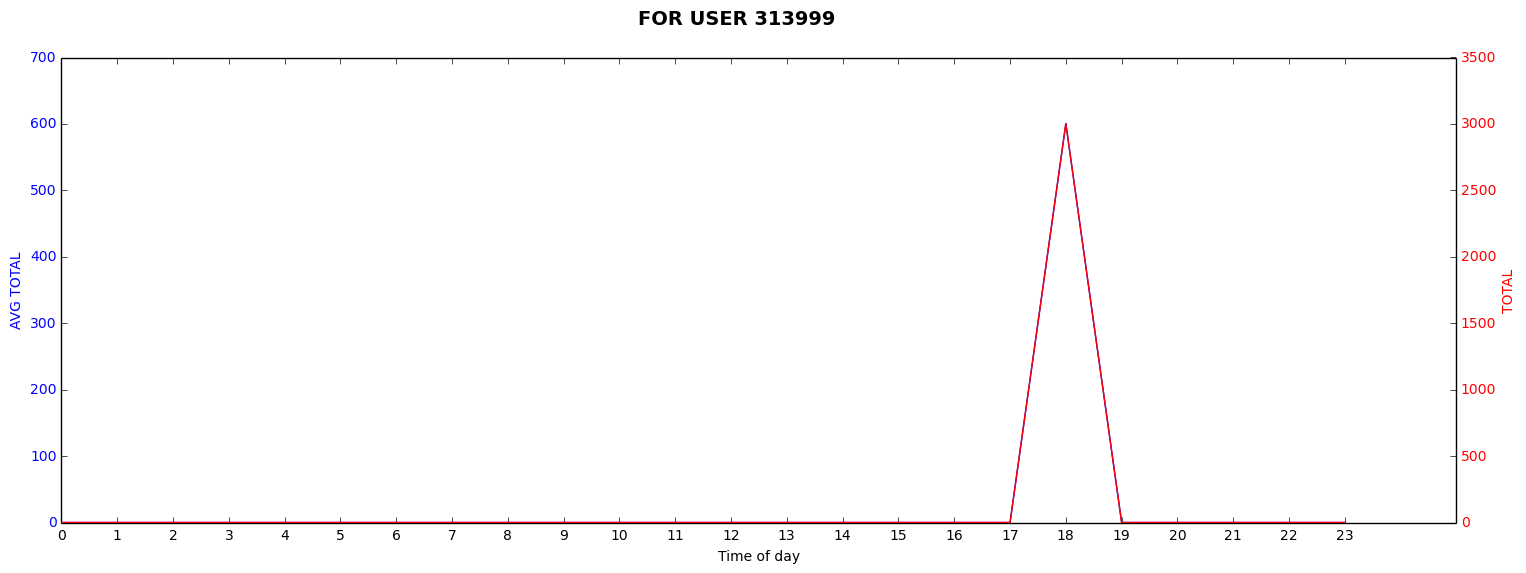

In [49]:
draw_scale(c_u_h.filter("USER_ID = '313999'"), "TIME_OF_DAY", "AVG_TOTAL", "TOTAL", "Time of day", "AVG TOTAL", "TOTAL", "FOR USER 313999")

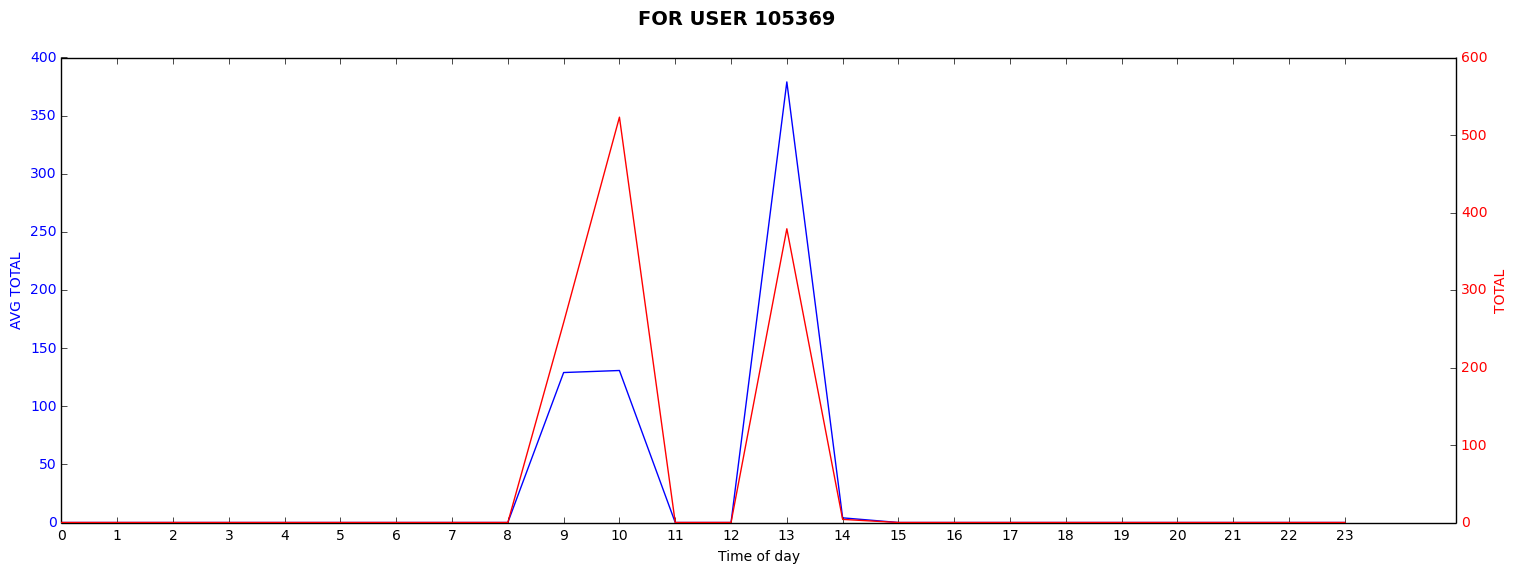

In [48]:
draw_scale(c_u_h.filter("USER_ID = '105369'"), "TIME_OF_DAY", "AVG_TOTAL", "TOTAL", "Time of day", "AVG TOTAL", "TOTAL", "FOR USER 105369")

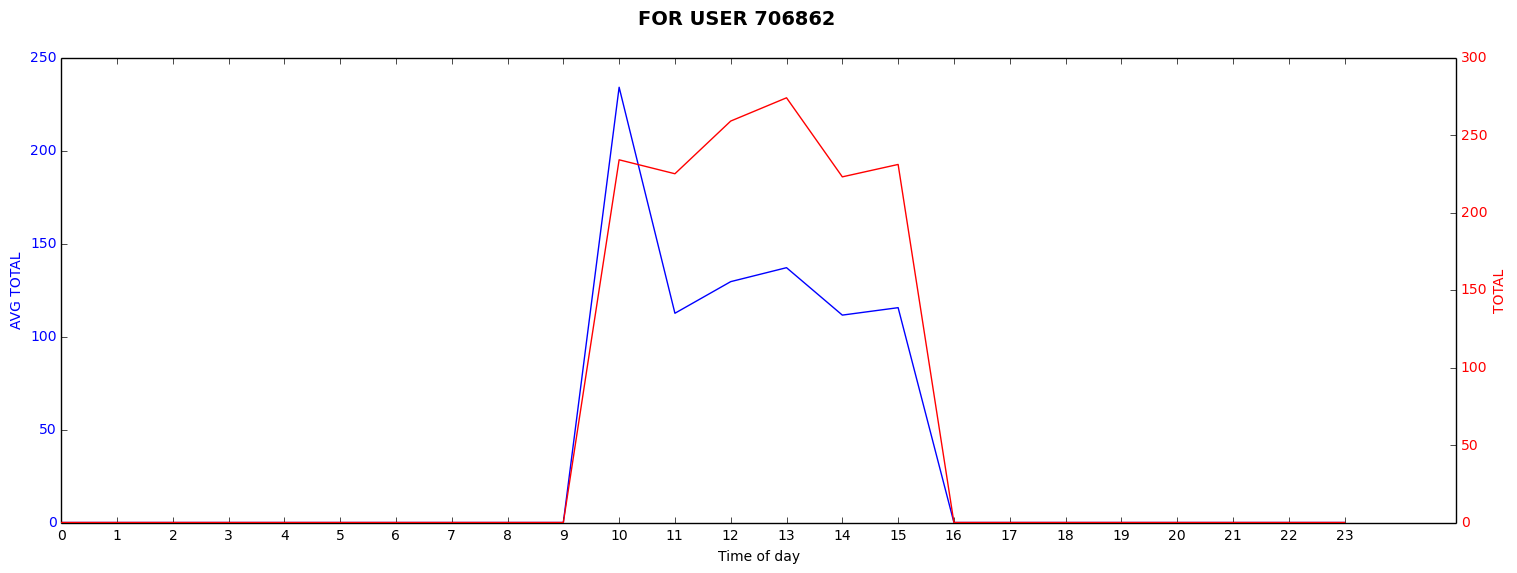

In [50]:
draw_scale(c_u_h.filter("USER_ID = '706862'"), "TIME_OF_DAY", "AVG_TOTAL", "TOTAL", "Time of day", "AVG TOTAL", "TOTAL", "FOR USER 706862")

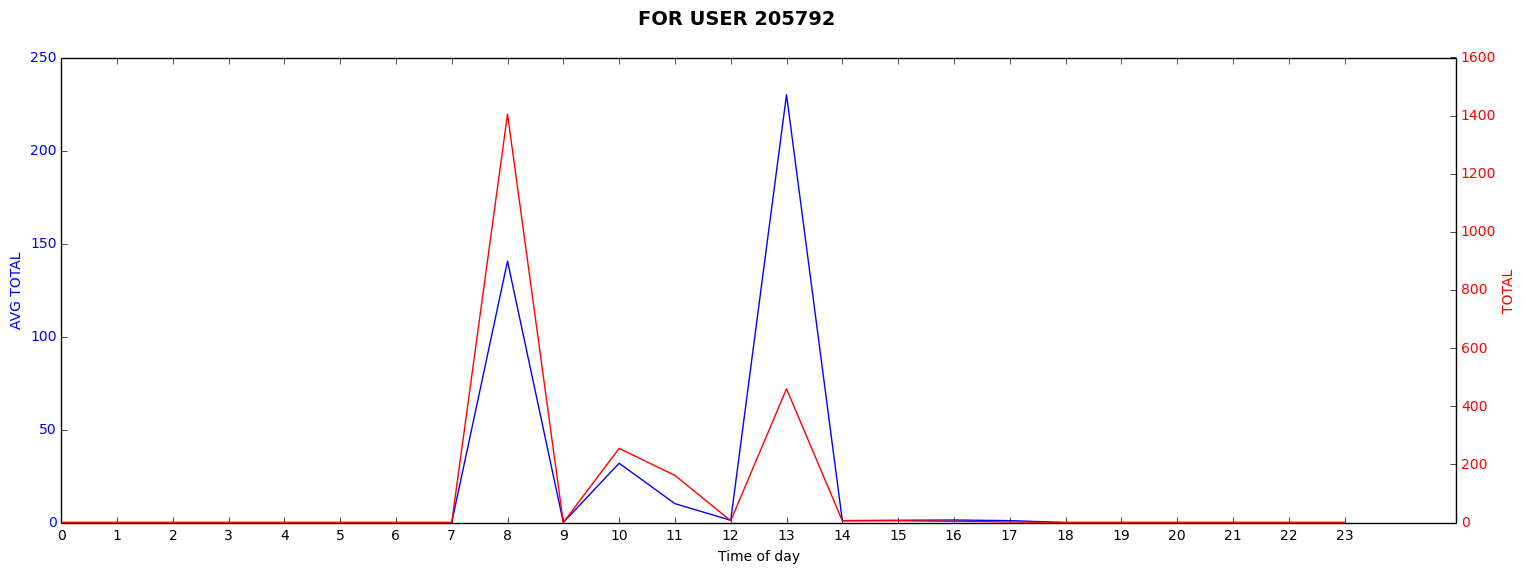

In [51]:
draw_scale(c_u_h.filter("USER_ID = '205792'"), "TIME_OF_DAY", "AVG_TOTAL", "TOTAL", "Time of day", "AVG TOTAL", "TOTAL", "FOR USER 205792")

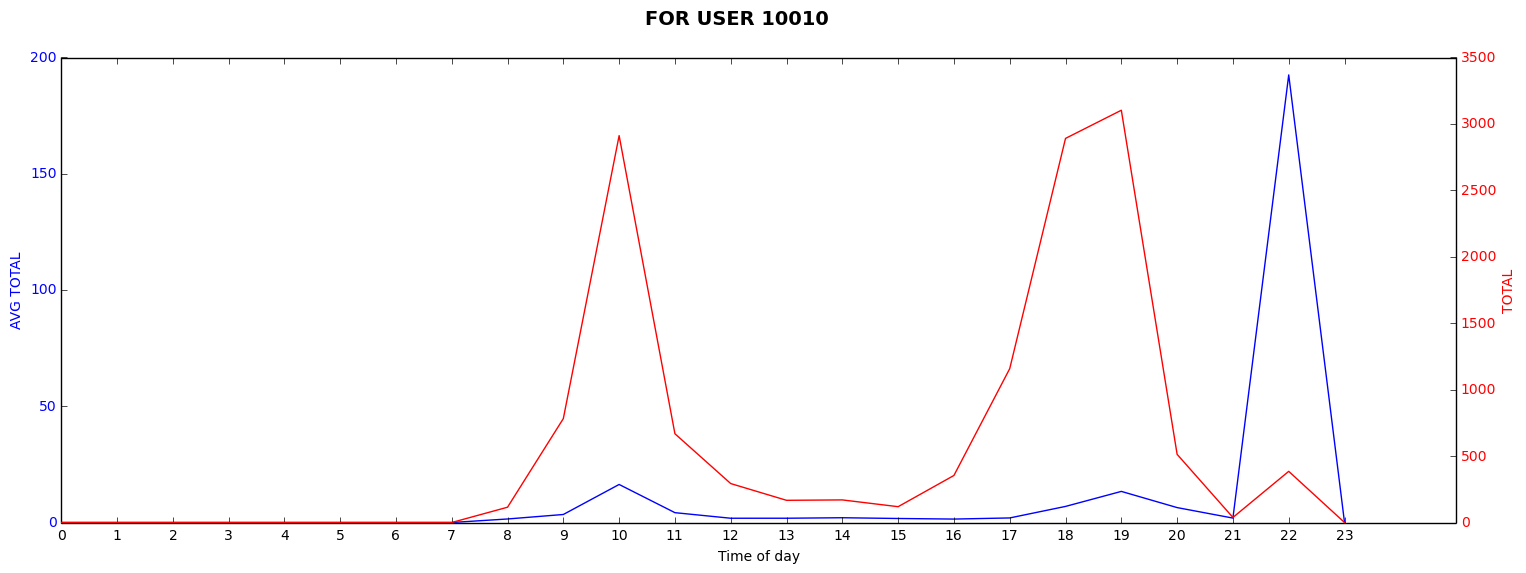

In [52]:
draw_scale(c_u_h.filter("USER_ID = '10010'"), "TIME_OF_DAY", "AVG_TOTAL", "TOTAL", "Time of day", "AVG TOTAL", "TOTAL", "FOR USER 10010")

In [62]:
c_u_h.unpersist()

DataFrame[USER_ID: string, TIME_OF_DAY: int, AVG_TOTAL: double, TOTAL: bigint]

##### by hour and patient

In [53]:
%%time
query = " ".join([
    "SELECT EPIC_PATIENT_ID, TIME_OF_DAY, AVG(TOTAL) AS AVG_TOTAL, SUM(TOTAL) AS TOTAL",
    "FROM (SELECT EPIC_PATIENT_ID, TIME_OF_DAY, ACCESS_DTTM, COUNT(EPIC_PATIENT_ID) AS TOTAL",
           "FROM with_print",
           "GROUP BY EPIC_PATIENT_ID, TIME_OF_DAY, ACCESS_DTTM) AS T",
    "GROUP BY TIME_OF_DAY, EPIC_PATIENT_ID",
    "ORDER BY AVG_TOTAL DESC"
])
c_p_h = sqlContext_H.sql(query).persist()

CPU times: user 64.6 ms, sys: 0 ns, total: 64.6 ms
Wall time: 3min 38s


In [55]:
%%time
c_p_h.limit(10).toPandas()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 60.6 ms


,EPIC_PATIENT_ID,TIME_OF_DAY,AVG_TOTAL,TOTAL
0,2110077,14,326.000000,326
1,2132225,16,323.800000,1619
2,3816919,10,259.000000,518
3,4153574,8,221.500000,1329
4,3738042,15,208.000000,208
5,5159851,13,153.000000,153
6,Z2725747,15,150.600000,753
7,4142944,13,146.000000,146
8,4127033,0,146.000000,146
9,3685016,15,124.714286,873


In [56]:
%%time
c_p_h.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_10_3_hour_patient.csv")

CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 4.94 s


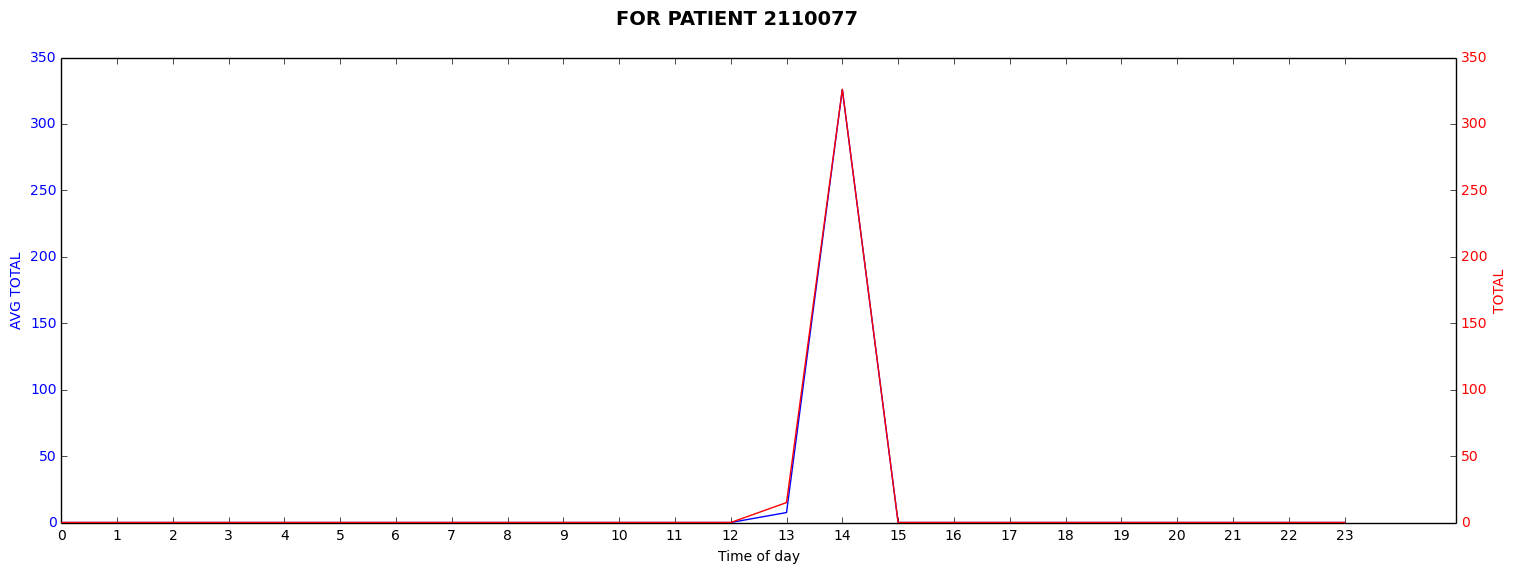

In [57]:
draw_scale(c_p_h.filter("EPIC_PATIENT_ID = '2110077'"), "TIME_OF_DAY", "AVG_TOTAL", "TOTAL", "Time of day", "AVG TOTAL", "TOTAL", "FOR PATIENT 2110077")

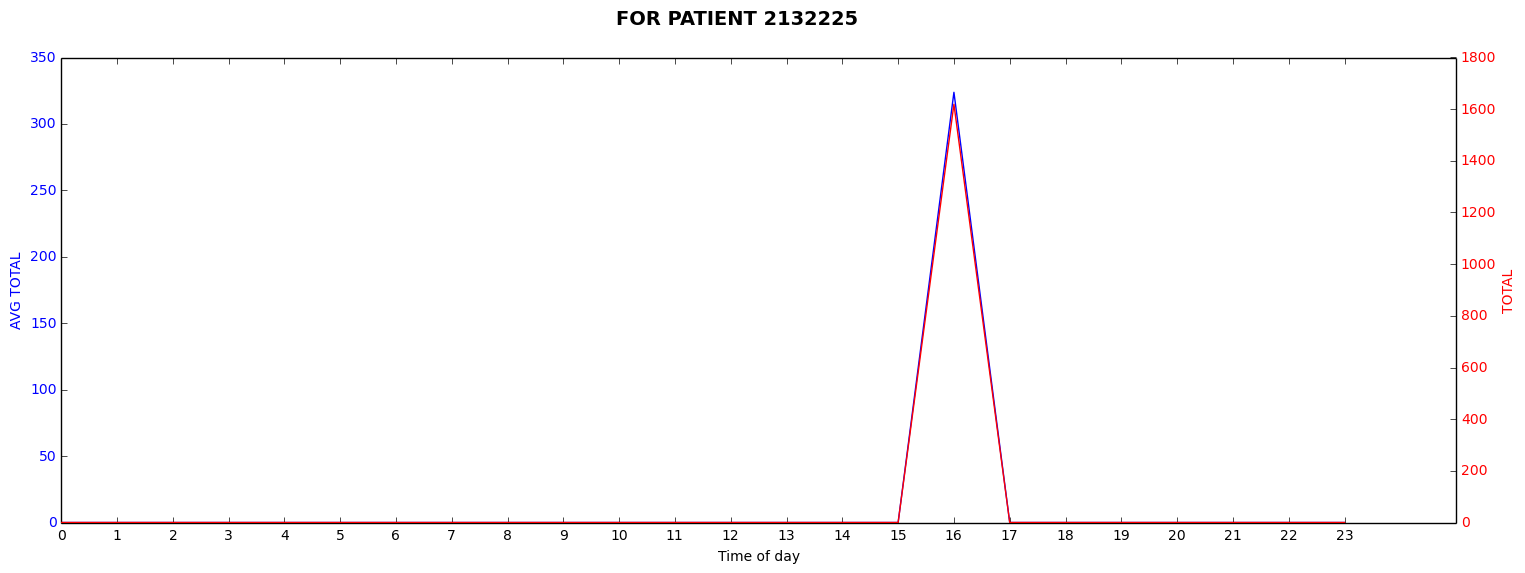

In [58]:
draw_scale(c_p_h.filter("EPIC_PATIENT_ID = '2132225'"), "TIME_OF_DAY", "AVG_TOTAL", "TOTAL", "Time of day", "AVG TOTAL", "TOTAL", "FOR PATIENT 2132225")

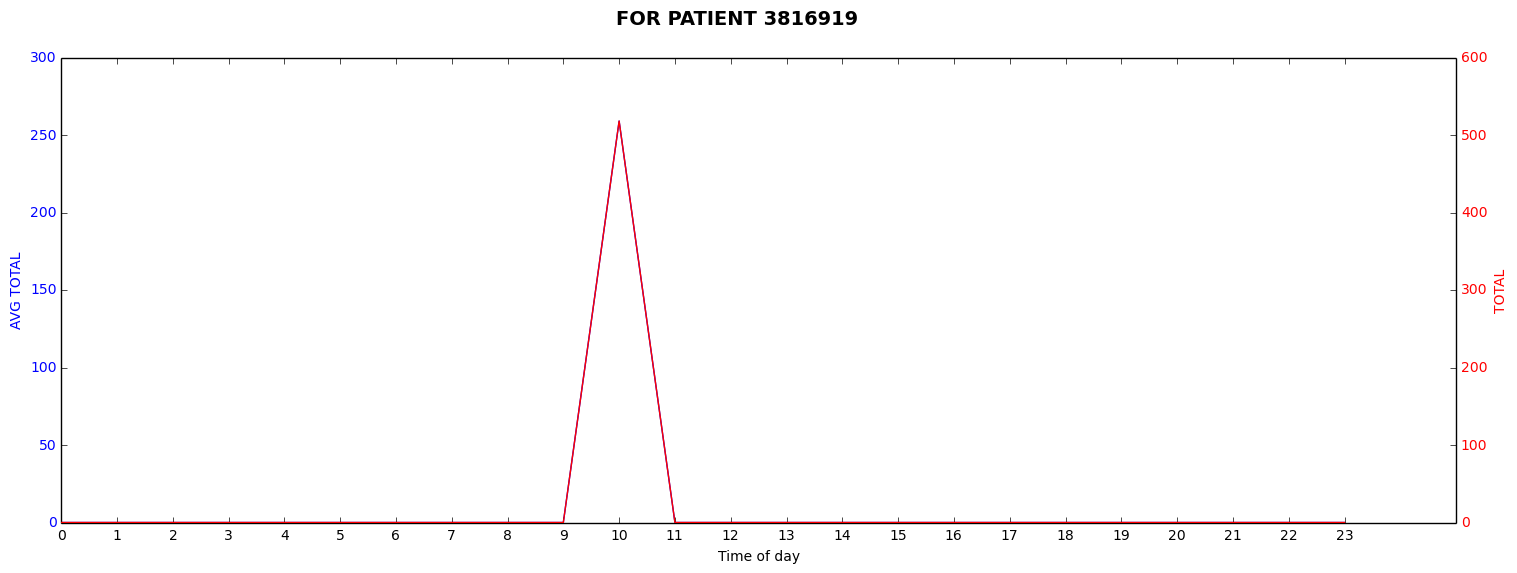

In [59]:
draw_scale(c_p_h.filter("EPIC_PATIENT_ID = '3816919'"), "TIME_OF_DAY", "AVG_TOTAL", "TOTAL", "Time of day", "AVG TOTAL", "TOTAL", "FOR PATIENT 3816919")

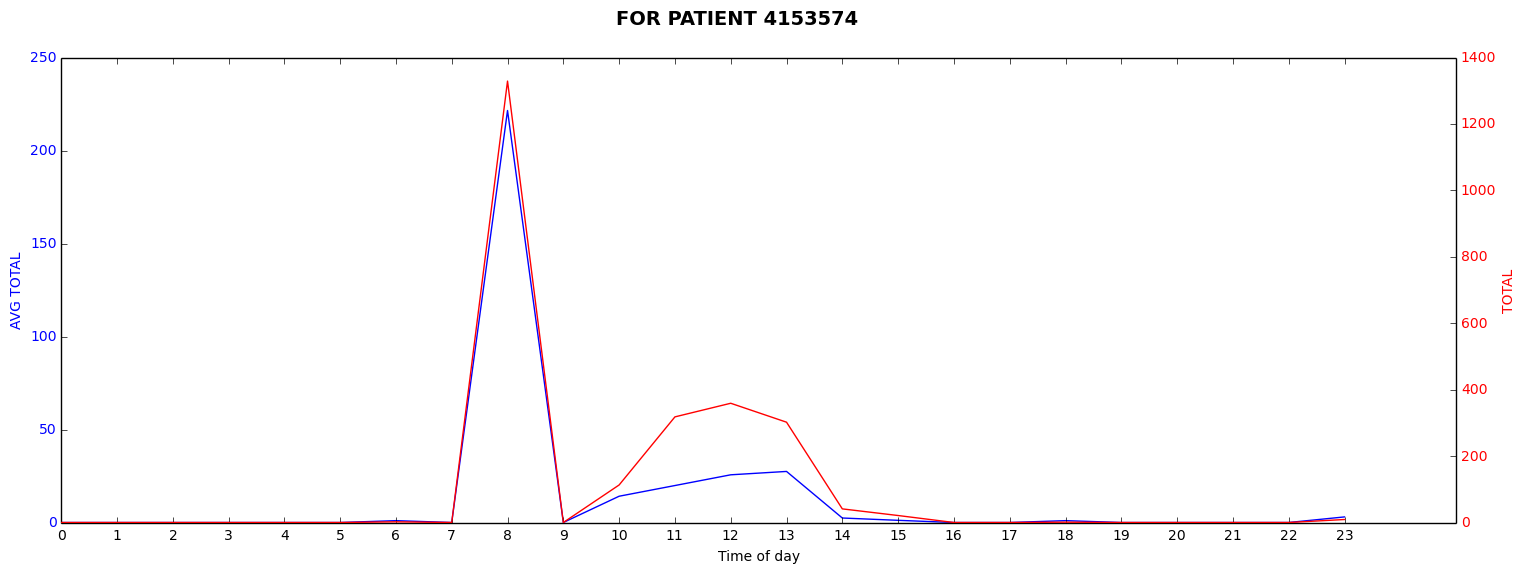

In [60]:
draw_scale(c_p_h.filter("EPIC_PATIENT_ID = '4153574'"), "TIME_OF_DAY", "AVG_TOTAL", "TOTAL", "Time of day", "AVG TOTAL", "TOTAL", "FOR PATIENT 4153574")

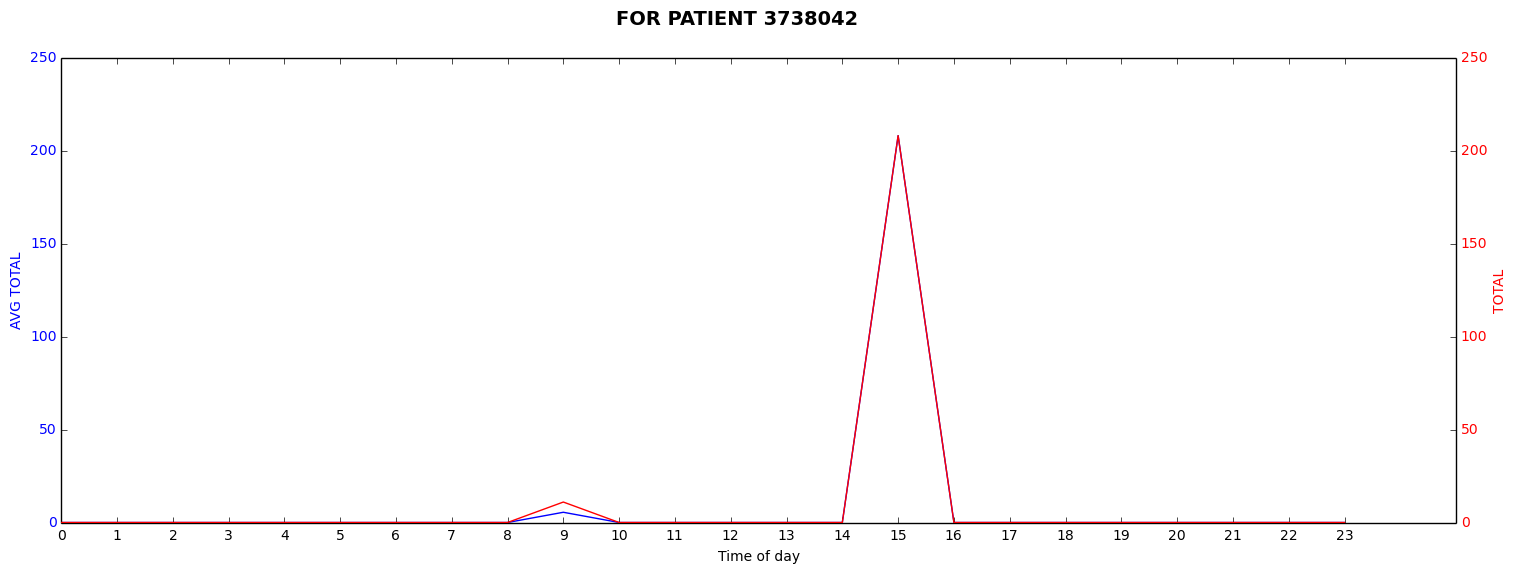

In [61]:
draw_scale(c_p_h.filter("EPIC_PATIENT_ID = '3738042'"), "TIME_OF_DAY", "AVG_TOTAL", "TOTAL", "Time of day", "AVG TOTAL", "TOTAL", "FOR PATIENT 3738042")

In [63]:
c_p_h.unpersist()

DataFrame[EPIC_PATIENT_ID: string, TIME_OF_DAY: int, AVG_TOTAL: double, TOTAL: bigint]

##### by day and user

In [64]:
%%time
query = " ".join([
    "SELECT USER_ID, DAY, AVG(TOTAL) AS AVG_TOTAL, SUM(TOTAL) AS TOTAL",
    "FROM (SELECT USER_ID, DAY, ACCESS_DTTM, COUNT(USER_ID) AS TOTAL",
           "FROM with_print",
           "GROUP BY USER_ID, DAY, ACCESS_DTTM) AS T",
    "GROUP BY DAY, USER_ID",
    "ORDER BY AVG_TOTAL DESC"
])
c_u_d = sqlContext_H.sql(query).persist()

CPU times: user 67.6 ms, sys: 0 ns, total: 67.6 ms
Wall time: 3min 42s


In [67]:
%%time
c_u_d.limit(10).toPandas()

CPU times: user 4.12 ms, sys: 0 ns, total: 4.12 ms
Wall time: 35.7 ms


,USER_ID,DAY,AVG_TOTAL,TOTAL
0,313999,2016-07-28,600.6,3003
1,105369,2016-09-12,379.0,379
2,205792,2016-09-12,299.0,299
3,205792,2016-08-29,297.0,297
4,313519,2016-08-26,291.2,1456
5,703698,2016-08-31,277.0,277
6,709849,2016-08-23,273.0,273
7,709849,2016-08-09,268.0,268
8,710010,2016-09-28,266.0,266
9,708771,2016-08-18,266.0,266


In [66]:
%%time
c_u_d.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_10_3_day_user.csv")

CPU times: user 9.83 ms, sys: 0 ns, total: 9.83 ms
Wall time: 1.76 s


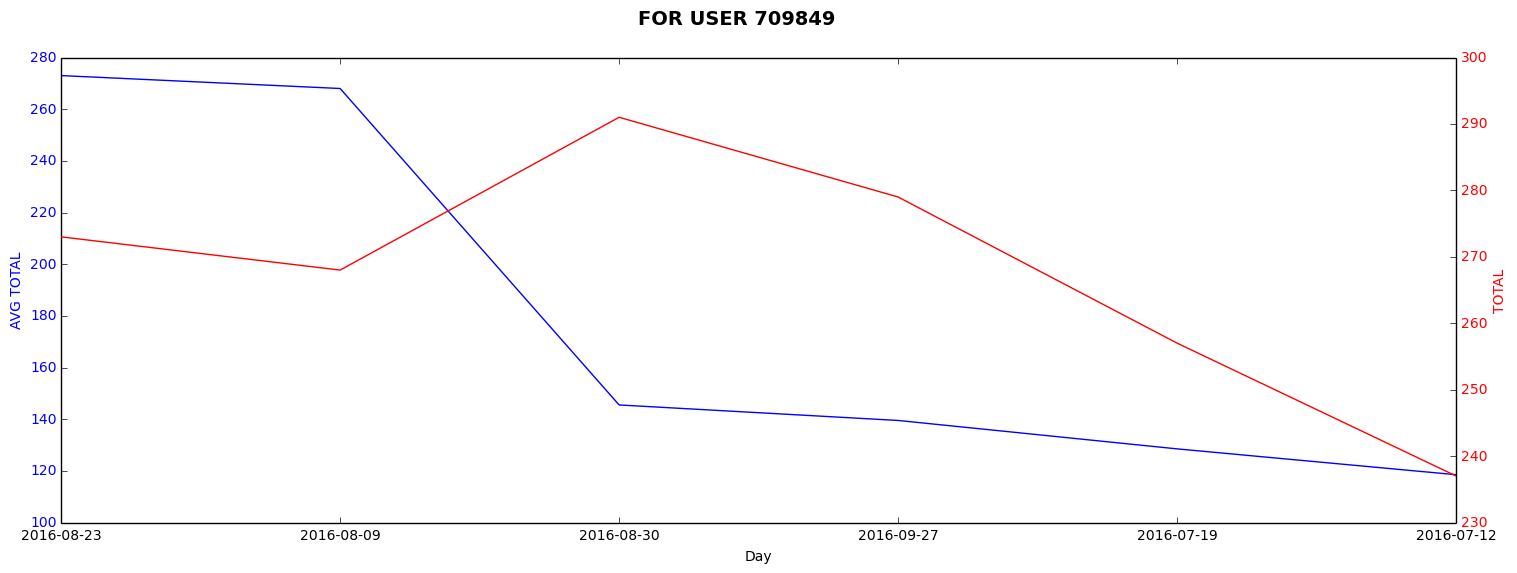

In [79]:
draw_scale(c_u_d.filter("USER_ID = '709849'"), "DAY", "AVG_TOTAL", "TOTAL", "Day", "AVG TOTAL", "TOTAL", "FOR USER 709849")

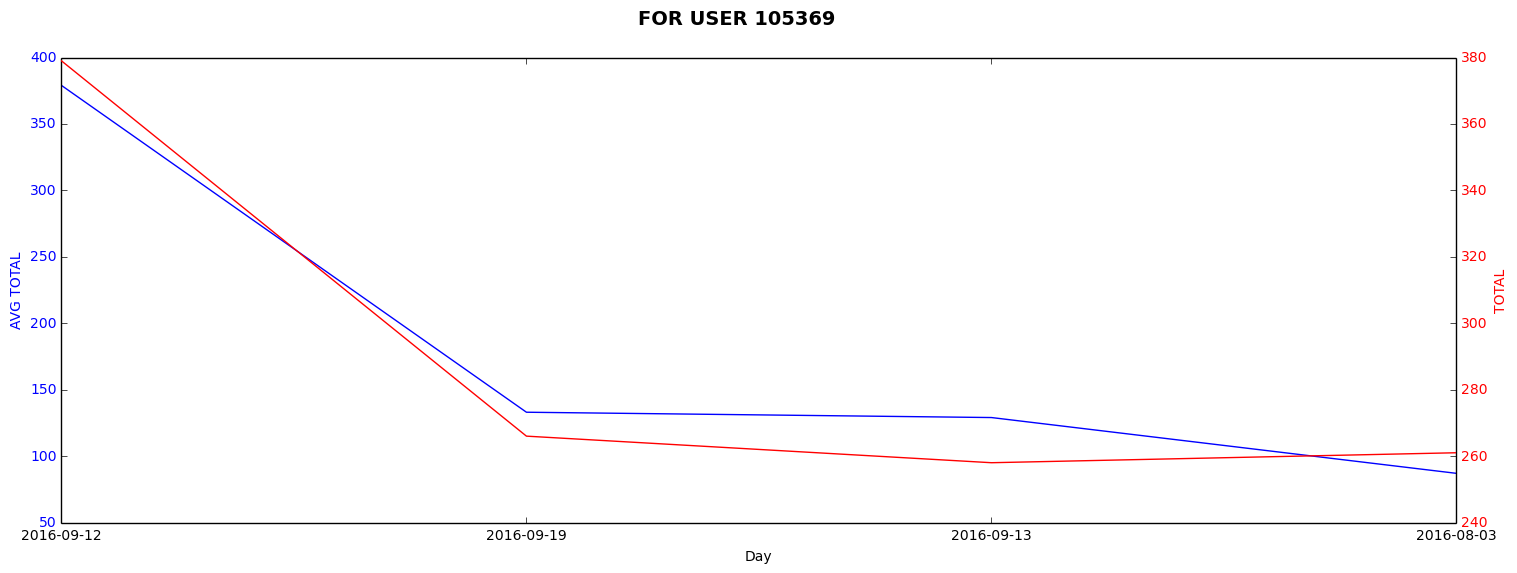

In [75]:
draw_scale(c_u_d.filter("USER_ID = '105369'"), "DAY", "AVG_TOTAL", "TOTAL", "Day", "AVG TOTAL", "TOTAL", "FOR USER 105369")

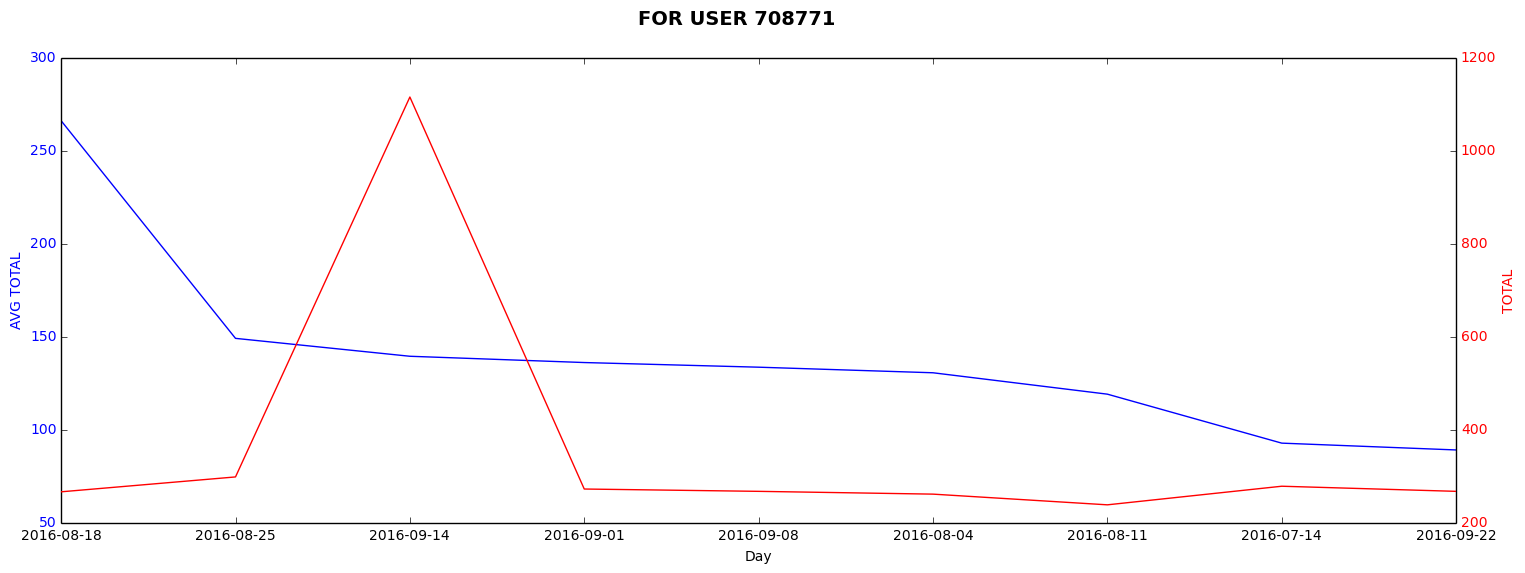

In [80]:
draw_scale(c_u_d.filter("USER_ID = '708771'"), "DAY", "AVG_TOTAL", "TOTAL", "Day", "AVG TOTAL", "TOTAL", "FOR USER 708771")

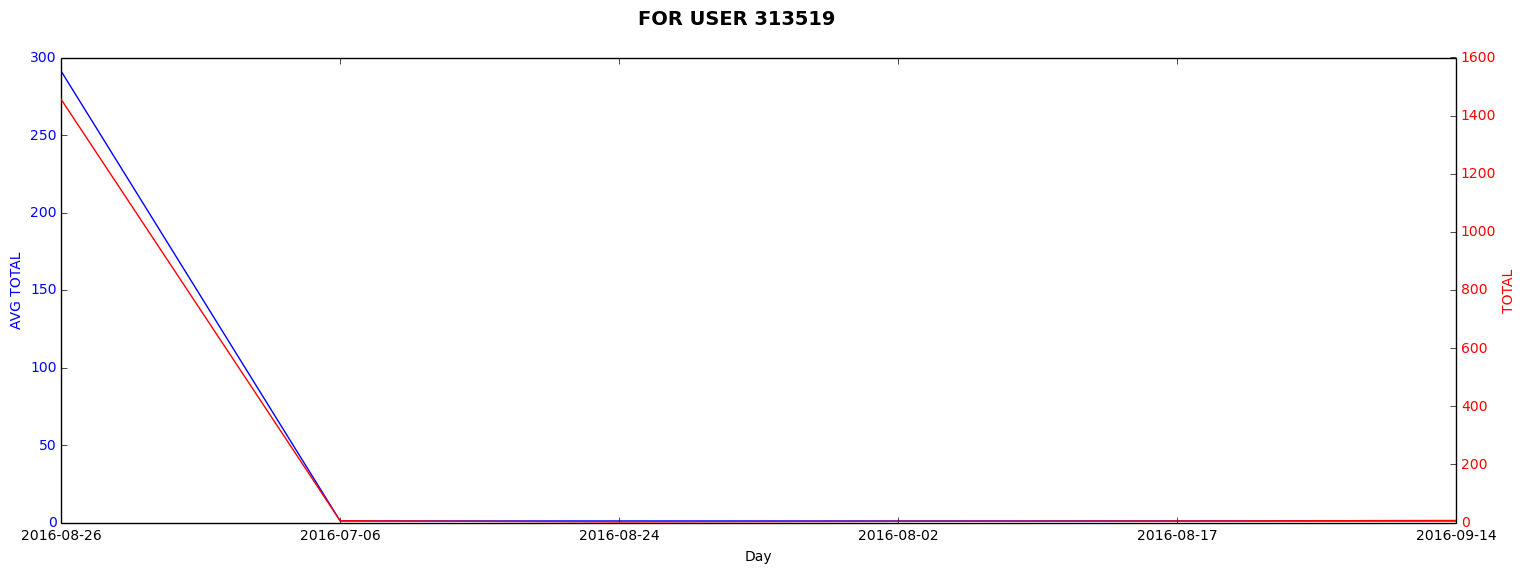

In [77]:
draw_scale(c_u_d.filter("USER_ID = '313519'"), "DAY", "AVG_TOTAL", "TOTAL", "Day", "AVG TOTAL", "TOTAL", "FOR USER 313519")

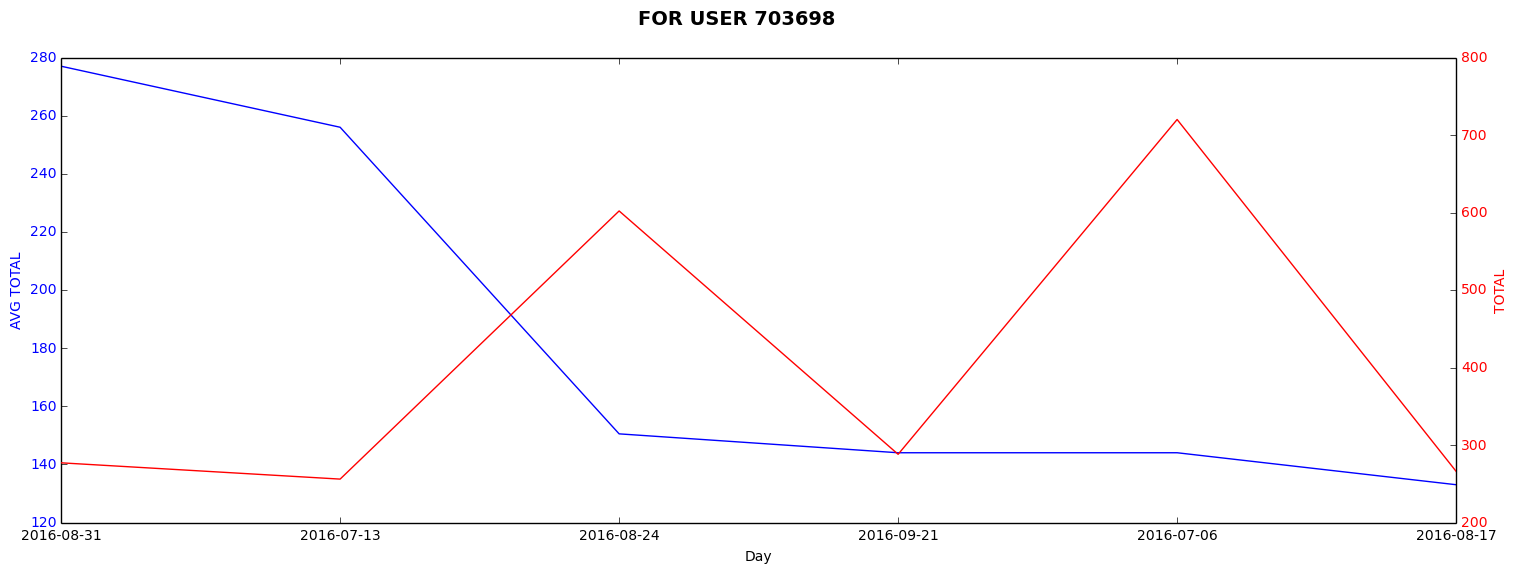

In [78]:
draw_scale(c_u_d.filter("USER_ID = '703698'"), "DAY", "AVG_TOTAL", "TOTAL", "Day", "AVG TOTAL", "TOTAL", "FOR USER 703698")

In [81]:
c_u_d.unpersist()

DataFrame[USER_ID: string, DAY: string, AVG_TOTAL: double, TOTAL: bigint]

##### by day and patient

In [82]:
%%time
query = " ".join([
    "SELECT EPIC_PATIENT_ID, DAY, AVG(TOTAL) AS AVG_TOTAL, SUM(TOTAL) AS TOTAL",
    "FROM (SELECT EPIC_PATIENT_ID, DAY, ACCESS_DTTM, COUNT(EPIC_PATIENT_ID) AS TOTAL",
           "FROM with_print",
           "GROUP BY EPIC_PATIENT_ID, DAY, ACCESS_DTTM) AS T",
    "GROUP BY DAY, EPIC_PATIENT_ID",
    "ORDER BY AVG_TOTAL DESC"
])
c_p_d = sqlContext_H.sql(query).persist()

CPU times: user 72.3 ms, sys: 2.72 ms, total: 75.1 ms
Wall time: 3min 41s


In [90]:
%%time
c_p_d.limit(25).toPandas()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 35.3 ms


,EPIC_PATIENT_ID,DAY,AVG_TOTAL,TOTAL
0,2132225,2016-07-08,323.800000,1619
1,3816919,2016-09-28,259.000000,518
2,4153574,2016-09-28,243.428571,1704
3,4164155,2016-08-30,240.000000,240
4,Z4127105,2016-07-28,215.000000,215
5,3738042,2016-08-25,208.000000,208
6,Z2725747,2016-07-18,192.125000,1537
7,4731261,2016-09-14,182.000000,364
8,4949609,2016-08-18,176.000000,176
9,3300436,2016-09-01,157.125000,1257


In [84]:
%%time
c_p_d.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_10_3_day_patient.csv")

CPU times: user 6.13 ms, sys: 71 µs, total: 6.2 ms
Wall time: 6.05 s


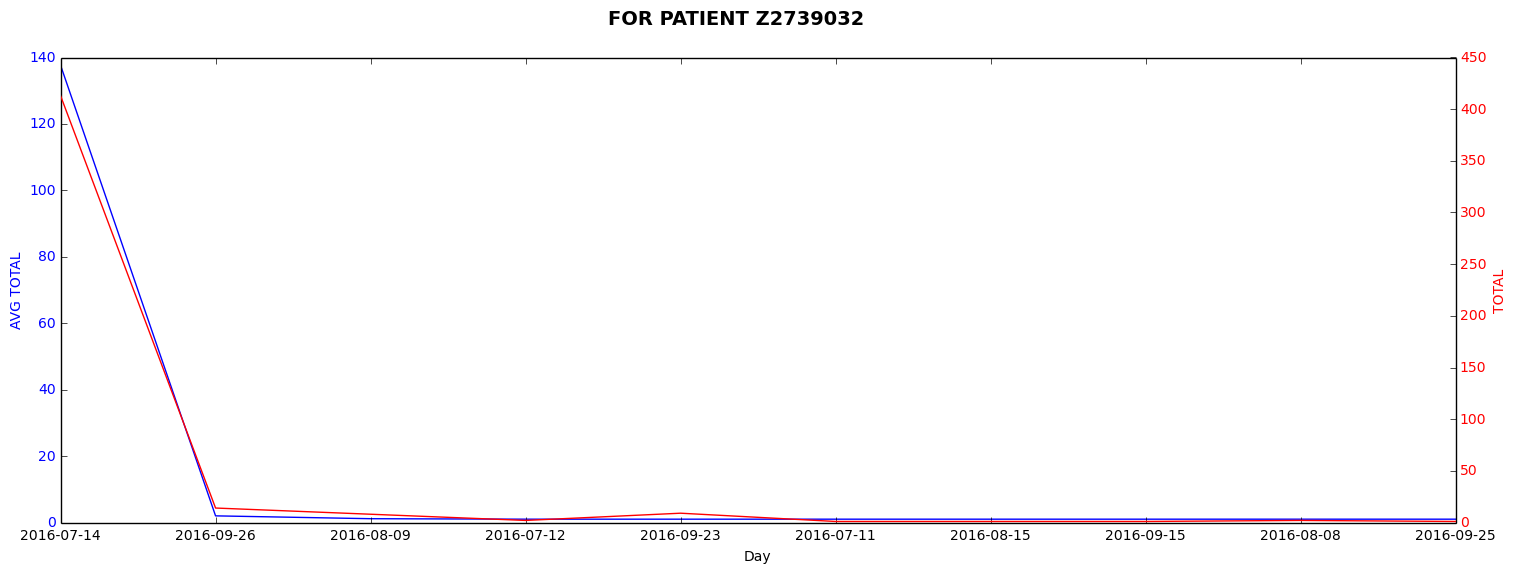

In [99]:
draw_scale(c_p_d.filter("EPIC_PATIENT_ID = 'Z2739032'"), "DAY", "AVG_TOTAL", "TOTAL", "Day", "AVG TOTAL", "TOTAL", "FOR PATIENT Z2739032")

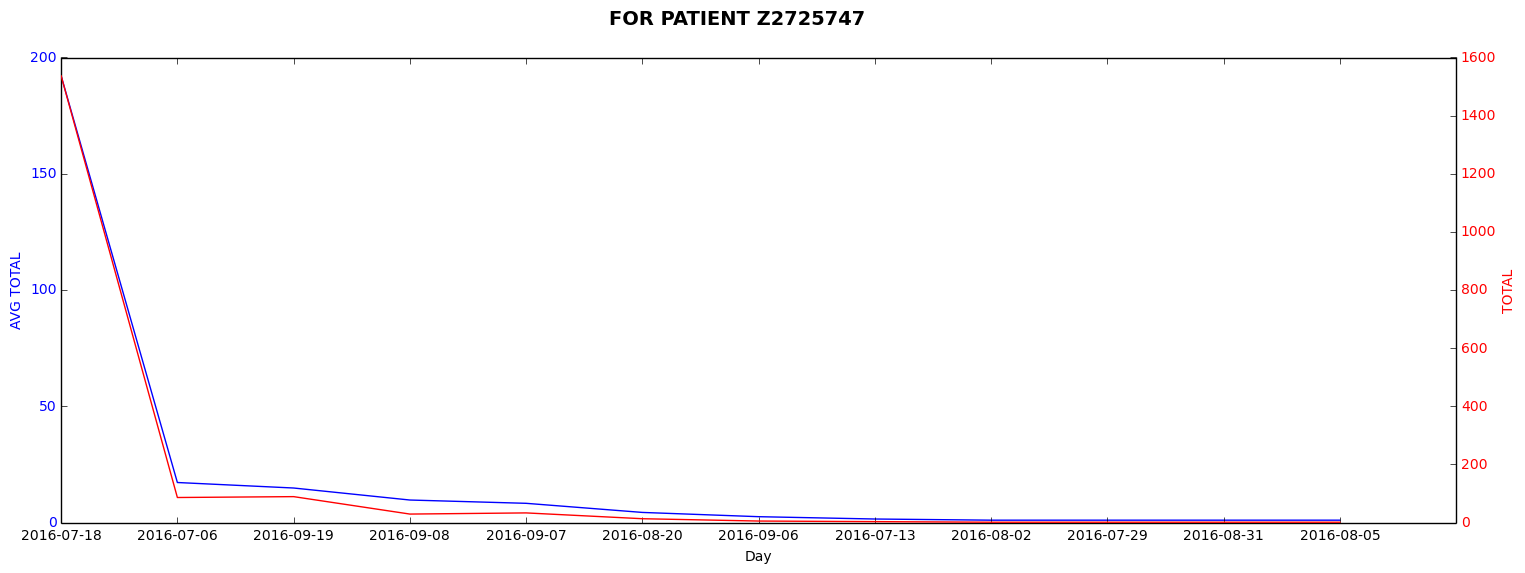

In [92]:
draw_scale(c_p_d.filter("EPIC_PATIENT_ID = 'Z2725747'"), "DAY", "AVG_TOTAL", "TOTAL", "Day", "AVG TOTAL", "TOTAL", "FOR PATIENT Z2725747")

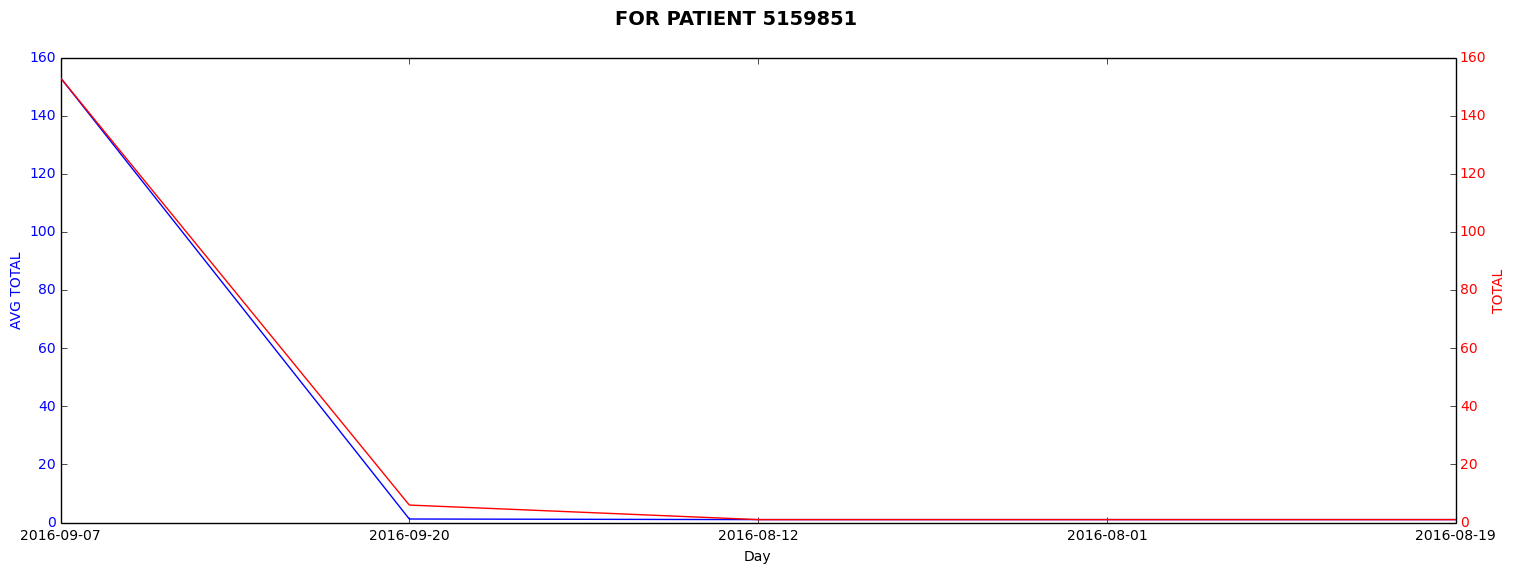

In [96]:
draw_scale(c_p_d.filter("EPIC_PATIENT_ID = '5159851'"), "DAY", "AVG_TOTAL", "TOTAL", "Day", "AVG TOTAL", "TOTAL", "FOR PATIENT 5159851")

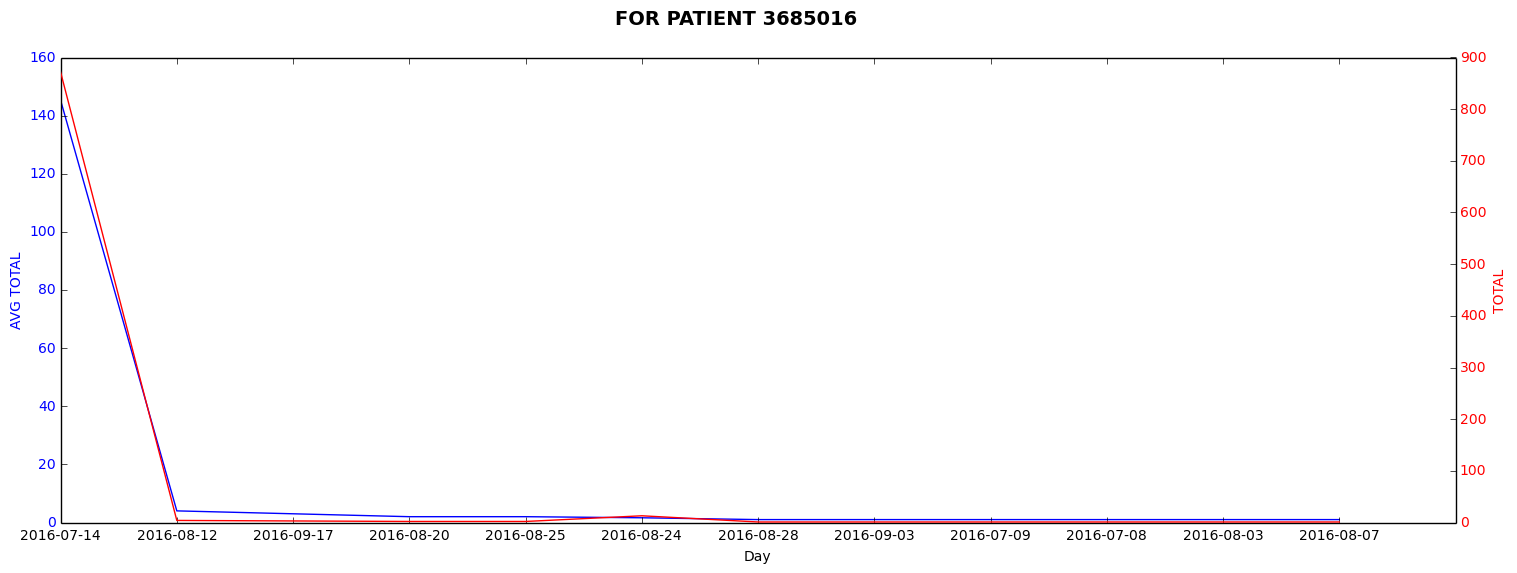

In [98]:
draw_scale(c_p_d.filter("EPIC_PATIENT_ID = '3685016'"), "DAY", "AVG_TOTAL", "TOTAL", "Day", "AVG TOTAL", "TOTAL", "FOR PATIENT 3685016")

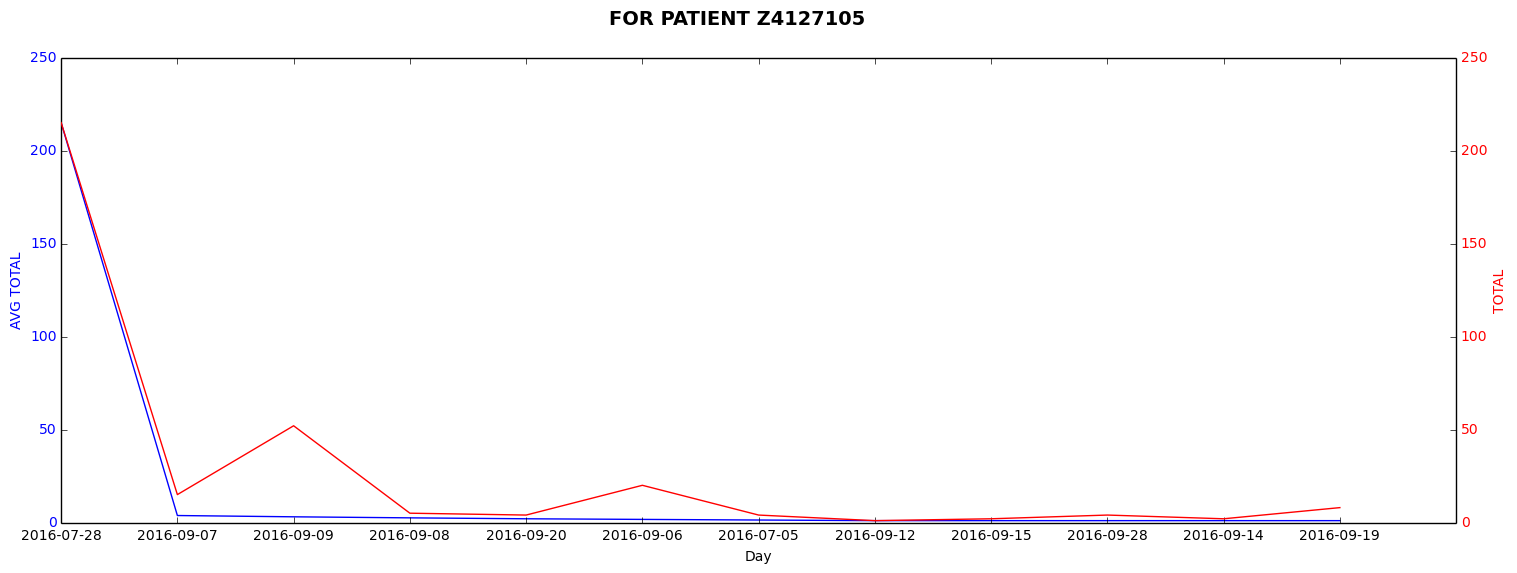

In [89]:
draw_scale(c_p_d.filter("EPIC_PATIENT_ID = 'Z4127105'"), "DAY", "AVG_TOTAL", "TOTAL", "Day", "AVG TOTAL", "TOTAL", "FOR PATIENT Z4127105")

In [100]:
c_p_d.unpersist()

DataFrame[EPIC_PATIENT_ID: string, DAY: string, AVG_TOTAL: double, TOTAL: bigint]

---
> * 21 METRIC_NAME with print.
> * Only one MODULE with print.
> * 24 METRIC_DESCRIPTION with print.
> * Around 11K users using print metrics, modules or metric descriptions.

---

---
### 9. What does REPORT_NAME mean, how many unique value, relationship with metrics, modules?

In [101]:
%%time
query = " ".join([
        "SELECT DISTINCT(REPORT_NAME), COUNT(REPORT_NAME) AS COUNT_REPORT_NAME",
        "FROM data_analysis",
        "GROUP BY REPORT_NAME",
        "ORDER BY COUNT_REPORT_NAME DESC"
    ])
u_rn = sqlContext_H.sql(query)

CPU times: user 1.26 ms, sys: 0 ns, total: 1.26 ms
Wall time: 13 ms


In [102]:
%%time
u_rn.limit(25).toPandas()

CPU times: user 26.5 ms, sys: 5.17 ms, total: 31.7 ms
Wall time: 6.89 s


,REPORT_NAME,COUNT_REPORT_NAME
0,View,260262205
1,,255412183
2,Exit,35279198
3,Accept,31446248
4,Printed/Sent by Order Transmittal,5010804
5,Print,2533697
6,Copy,1465043
7,Barcode,806089
8,Timeout,101969
9,Automated Accept,87791


##### group by MODULE

In [103]:
%%time
u_rn.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_11_REPORT_NAME.csv")

CPU times: user 28.4 ms, sys: 908 µs, total: 29.3 ms
Wall time: 6.97 s


In [105]:
%%time
query = " ".join([
        "SELECT MODULE, REPORT_NAME, COUNT(REPORT_NAME) AS COUNT_REPORT_NAME",
        "FROM data_analysis",
        "WHERE REPORT_NAME != '' OR REPORT_NAME != null OR REPORT_NAME = 'None'"
        "GROUP BY MODULE, REPORT_NAME",
        "ORDER BY MODULE ASC"
    ])
u_rn_rep_mo = sqlContext_H.sql(query)

CPU times: user 0 ns, sys: 4.57 ms, total: 4.57 ms
Wall time: 22.8 ms


In [106]:
%%time
u_rn_rep_mo.limit(50).toPandas()

CPU times: user 27.8 ms, sys: 768 µs, total: 28.6 ms
Wall time: 10.7 s


,MODULE,REPORT_NAME,COUNT_REPORT_NAME
0,AP Claims,View,40136
1,Abstraction Tool,Accept,366
2,Benefit Plan,Accept,94734
3,CHART RELEASE INFO,Print,968
4,CHART RELEASE INFO,Save to File,11418
5,CHART RELEASE INFO,View,3712
6,CHART RELEASE INFO,Fax,2011
7,DEMOGRAPHIC,View,4101
8,DEMOGRAPHIC,Accept,19
9,LOG ENTRY,View,190


In [107]:
%%time
u_rn_rep_mo.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_11_MODULE_REPORT_NAME.csv")

CPU times: user 27.3 ms, sys: 909 µs, total: 28.2 ms
Wall time: 10.8 s


In [108]:
%%time
query = " ".join([
        "SELECT MODULE, METRIC_NAME, REPORT_NAME, COUNT(REPORT_NAME) AS COUNT_REPORT_NAME",
        "FROM data_analysis",
        "WHERE REPORT_NAME != '' OR REPORT_NAME != null OR REPORT_NAME = 'None'"
        "GROUP BY MODULE, METRIC_NAME, REPORT_NAME",
        "ORDER BY MODULE ASC"
    ])
u_rn_rep_mo_me = sqlContext_H.sql(query)

CPU times: user 1.04 ms, sys: 0 ns, total: 1.04 ms
Wall time: 30.4 ms


In [109]:
%%time
u_rn_rep_mo_me.limit(10).toPandas()

CPU times: user 26.2 ms, sys: 872 µs, total: 27.1 ms
Wall time: 12.3 s


,MODULE,METRIC_NAME,REPORT_NAME,COUNT_REPORT_NAME
0,AP Claims,EW_CLM_BY_MEMBER,View,37385
1,AP Claims,EW_CLM_DETAIL,View,2751
2,Abstraction Tool,IP_ABST_TOOL,Accept,366
3,Benefit Plan,MR_VERIFY_RX_BENEFITS,Accept,94734
4,CHART RELEASE INFO,HIM_ROI_RELEASE_OF_INFORMATION,Print,968
5,CHART RELEASE INFO,HIM_ROI_RELEASE_OF_INFORMATION,Fax,2011
6,CHART RELEASE INFO,HIM_ROI_RELEASE_OF_INFORMATION,View,3712
7,CHART RELEASE INFO,HIM_ROI_RELEASE_OF_INFORMATION,Save to File,11418
8,DEMOGRAPHIC,AC_PATIENT_PHOTO,View,4101
9,DEMOGRAPHIC,AC_PATIENT_PHOTO,Accept,19


In [110]:
%%time
u_rn_rep_mo_me.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_11_MODULE_REPORT_NAME_METRIC_NAME.csv")

CPU times: user 30.3 ms, sys: 698 µs, total: 31 ms
Wall time: 12.5 s


In [113]:
%%time
query = " ".join([
        "SELECT MODULE, concat_ws(';', collect_set(METRIC_NAME)) AS METRIC_NAME, REPORT_NAME, COUNT(REPORT_NAME) AS COUNT_REPORT_NAME",
        "FROM data_analysis",
        "WHERE REPORT_NAME != '' OR REPORT_NAME != null OR REPORT_NAME = 'None'"
        "GROUP BY MODULE, REPORT_NAME",
        "ORDER BY MODULE ASC"
    ])
u_rn_rep_mo_me_g = sqlContext_H.sql(query)

CPU times: user 1.04 ms, sys: 0 ns, total: 1.04 ms
Wall time: 26.1 ms


In [114]:
%%time
u_rn_rep_mo_me_g.limit(10).toPandas()

CPU times: user 46 ms, sys: 1.55 ms, total: 47.5 ms
Wall time: 3min 22s


,MODULE,METRIC_NAME,REPORT_NAME,COUNT_REPORT_NAME
0,AP Claims,EW_CLM_DETAIL;EW_CLM_BY_MEMBER,View,40136
1,Abstraction Tool,IP_ABST_TOOL,Accept,366
2,Benefit Plan,MR_VERIFY_RX_BENEFITS,Accept,94734
3,CHART RELEASE INFO,HIM_ROI_RELEASE_OF_INFORMATION,Print,968
4,CHART RELEASE INFO,HIM_ROI_RELEASE_OF_INFORMATION,View,3712
5,CHART RELEASE INFO,HIM_ROI_RELEASE_OF_INFORMATION,Fax,2011
6,CHART RELEASE INFO,HIM_ROI_RELEASE_OF_INFORMATION,Save to File,11418
7,DEMOGRAPHIC,AC_PATIENT_PHOTO,View,4101
8,DEMOGRAPHIC,AC_PATIENT_PHOTO,Accept,19
9,LOG ENTRY,EW_PATIENT_HIGHLIGHTS;EW_BILLING_INFO_VIEWED,View,190


In [115]:
%%time
u_rn_rep_mo_me_g.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_11_MODULE_REPORT_NAME_METRIC_NAME_G.csv")

CPU times: user 54.4 ms, sys: 6.66 ms, total: 61 ms
Wall time: 5min 30s


##### group by METRIC_NAME

In [116]:
%%time
query = " ".join([
        "SELECT METRIC_NAME, REPORT_NAME, COUNT(REPORT_NAME) AS COUNT_REPORT_NAME",
        "FROM data_analysis",
        "WHERE REPORT_NAME != '' OR REPORT_NAME != null OR REPORT_NAME = 'None'"
        "GROUP BY METRIC_NAME, REPORT_NAME",
        "ORDER BY METRIC_NAME ASC"
    ])
u_rn_rep_me = sqlContext_H.sql(query).persist()

CPU times: user 17.4 ms, sys: 10.1 ms, total: 27.5 ms
Wall time: 11.6 s


In [117]:
%%time
u_rn_rep_me.limit(10).toPandas()

CPU times: user 3.74 ms, sys: 0 ns, total: 3.74 ms
Wall time: 682 ms


,METRIC_NAME,REPORT_NAME,COUNT_REPORT_NAME
0,AC_PATIENT_PHOTO,Accept,19
1,AC_PATIENT_PHOTO,View,4101
2,AC_PCPHISTORY,Exit,111260
3,AC_PCPHISTORY,View,2099676
4,AC_PCPHISTORY,Accept,111789
5,AC_VISIT_NAVIGATOR,View,10087353
6,AN_EVENTS,Accept,16400
7,AN_INTRAOP,View,14
8,AN_IN_FLO,Accept,2
9,AN_IN_MEDS,Accept,4712


In [118]:
%%time
u_rn_rep_me.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_11_METRIC_NAME_REPORT_NAME.csv")

CPU times: user 1.54 ms, sys: 53 µs, total: 1.59 ms
Wall time: 1.4 s


In [119]:
u_rn_rep_me.unpersist()

DataFrame[METRIC_NAME: string, REPORT_NAME: string, COUNT_REPORT_NAME: bigint]

In [120]:
%%time
query = " ".join([
        "SELECT METRIC_NAME, MODULE, REPORT_NAME, COUNT(REPORT_NAME) AS COUNT_REPORT_NAME",
        "FROM data_analysis",
        "WHERE REPORT_NAME != '' OR REPORT_NAME != null OR REPORT_NAME = 'None'"
        "GROUP BY METRIC_NAME, MODULE, REPORT_NAME",
        "ORDER BY METRIC_NAME ASC"
    ])
u_rn_rep_me_mo = sqlContext_H.sql(query).persist()

CPU times: user 24.5 ms, sys: 5.7 ms, total: 30.2 ms
Wall time: 12.4 s


In [121]:
%%time
u_rn_rep_me_mo.limit(10).toPandas()

CPU times: user 3.95 ms, sys: 0 ns, total: 3.95 ms
Wall time: 925 ms


,METRIC_NAME,MODULE,REPORT_NAME,COUNT_REPORT_NAME
0,AC_PATIENT_PHOTO,DEMOGRAPHIC,Accept,19
1,AC_PATIENT_PHOTO,DEMOGRAPHIC,View,4101
2,AC_PCPHISTORY,PCP History,Accept,111789
3,AC_PCPHISTORY,PCP History,View,2099676
4,AC_PCPHISTORY,PCP History,Exit,111260
5,AC_VISIT_NAVIGATOR,PATIENT CLINICAL INFO,View,10087353
6,AN_EVENTS,PATIENT CLINICAL INFO,Accept,16400
7,AN_INTRAOP,PATIENT CLINICAL INFO,View,14
8,AN_IN_FLO,PATIENT CLINICAL INFO,Accept,2
9,AN_IN_MEDS,PATIENT CLINICAL INFO,Accept,4712


In [122]:
%%time
u_rn_rep_me_mo.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_11_METRIC_NAME_REPORT_NAME_MODULE.csv")

CPU times: user 1.53 ms, sys: 54 µs, total: 1.58 ms
Wall time: 1.5 s


In [123]:
u_rn_rep_me_mo.unpersist()

DataFrame[METRIC_NAME: string, MODULE: string, REPORT_NAME: string, COUNT_REPORT_NAME: bigint]

In [136]:
%%time
query = " ".join([
        "SELECT METRIC_NAME, concat_ws(';', collect_set(MODULE)) AS MODULE, REPORT_NAME, COUNT(REPORT_NAME) AS COUNT_REPORT_NAME",
        "FROM data_analysis",
        "WHERE REPORT_NAME != '' OR REPORT_NAME != null OR REPORT_NAME = 'None'"
        "GROUP BY METRIC_NAME, REPORT_NAME",
        "ORDER BY METRIC_NAME ASC"
    ])
u_rn_rep_me_mo_g = sqlContext_H.sql(query).persist()

CPU times: user 32 ms, sys: 5.91 ms, total: 37.9 ms
Wall time: 1min 47s


In [137]:
%%time
u_rn_rep_me_mo_g.limit(10).toPandas()

CPU times: user 13 ms, sys: 481 µs, total: 13.5 ms
Wall time: 1min 35s


,METRIC_NAME,MODULE,REPORT_NAME,COUNT_REPORT_NAME
0,AC_PATIENT_PHOTO,DEMOGRAPHIC,View,4101
1,AC_PATIENT_PHOTO,DEMOGRAPHIC,Accept,19
2,AC_PCPHISTORY,PCP History,Accept,111789
3,AC_PCPHISTORY,PCP History,Exit,111260
4,AC_PCPHISTORY,PCP History,View,2099676
5,AC_VISIT_NAVIGATOR,PATIENT CLINICAL INFO,View,10087353
6,AN_EVENTS,PATIENT CLINICAL INFO,Accept,16400
7,AN_INTRAOP,PATIENT CLINICAL INFO,View,14
8,AN_IN_FLO,PATIENT CLINICAL INFO,Accept,2
9,AN_IN_MEDS,PATIENT CLINICAL INFO,Accept,4712


In [140]:
%%time
u_rn_rep_me_mo_g.write.format("com.databricks.spark.csv").save(HOST + "/csv/EDA_METRICS_11_METRIC_NAME_REPORT_NAME_MODULE_G.csv")

CPU times: user 1.15 ms, sys: 43 µs, total: 1.19 ms
Wall time: 1.03 s


In [141]:
u_rn_rep_me_mo_g.unpersist()

DataFrame[METRIC_NAME: string, MODULE: string, REPORT_NAME: string, COUNT_REPORT_NAME: bigint]

---
> * Total unique REPORT_NAME amount is 14.
> * The are no relations between MODULE/METRIC_NAME and REPORT_NAME.

---